In [318]:
import matplotlib.pyplot as plt
import math
import itertools
import pandas as pd
import numpy as np
import random
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import levene

In [3]:
BASE = 2
class PascalModulo:
    def __init__(self,base):
        self.base = base
        self.diags = [[1]]
        
    #Add a diagonal and fill it
    def _add(self):
        self.diags[0].append(1)
        i = 1
        while i <= len(self.diags) - 1:
            self.diags[i].append( (self.diags[i-1][len(self.diags[i])] + self.diags[i][len(self.diags[i]) - 1]) % self.base )
            i+=1
        self.diags.append([1])
            
    #Get element
    def get(self,i,j):
        if (i < 1 or j < 1):
            return 1
        # Compute diagonal if not computed yet
        while (len(self.diags[0]) <= i+j):
            self._add()
        return self.diags[i][j]
    
    
# sierp = PascalModulo(BASE)
# sierp.get(7,7)
# sierp.diags 

In [354]:
class Levin:
    
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        self.sierp = PascalModulo(2)
    
    def get_next_digit(self):
#       print('block: ' + str(self.block) + ' ' + str(self.block_index))
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size += 1
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = 0
        for j in range(self.size):
            res += self.sierp.get(self.block_index,self.size-j-1) * self.block[j]
        self.block_index += 1
        return res%2
    
class Champernowne:
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        
    def get_next_digit(self):
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size += 1
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = self.block[self.block_index]
        self.block_index += 1
        return res%2
    
class PRNG:
    def get_next_digit(self):
        return random.choice([0,1])
    
class Rule30:
    
    def __init__(self,lencells=100):
        self.lencells = lencells
        self.cells = '1' + '0' * (lencells - 1)
        self.gen = self.eca_wrap()
    
    def eca_wrap(self):
        rulebits = '{0:08b}'.format(30)
        neighbours2next = {tuple('{0:03b}'.format(n)):rulebits[::-1][n] for n in range(8)}
        c = self.cells
        while True:
            yield c
            c = ''.join(neighbours2next[(c[i-1], c[i], c[(i+1) % self.lencells])] for i in range(self.lencells))
        
    
    def get_next_digit(self):
        return next(self.gen)[0]

In [ ]:
def get_occurrences(amounts,M):
    #returns frequency of occurencies for each value in the observed range
    occs = {}
    total = 0    
    for k,v in amounts.items():
        total += 1
        if v not in occs:
            occs[v] = 0
        occs[v] = occs[v] + 1
    occs[0] = int(2**M - total)
    max_o = 0
    for k,v in occs.items():
#         occs[k] = v/2**M
        occs[k] = v
        if k > max_o:
            max_o = k
    occs_array = [occs[i] if i in occs  else 0 for i in range(max_o+1)]
    return occs_array

In [279]:
def get_M(N,lamb):
    return int(math.ceil(math.log(N,2) - math.log(lamb,2)))

def normalize_data(occs, N, lamb):
    M = get_M(N,lamb)
    ret = []
    for o in occs:
        ret.append(o/2**M)
    return ret

def get_mean(normalized_occs):
    mean = 0
    for i in range(len(normalized_occs)):
        mean += i*normalized_occs[i]
    return mean

def get_std(normalized_occs,mean):
    if mean == None:
        mean = get_mean(normalized_occs)
        
    std = 0
    for i in range(len(normalized_occs)):
        std += ((i-mean)**2)*normalized_occs[i]
    return std

In [356]:
def get_amounts_for_ns(Ns,lamb=1,use_seq='levin'):
    if use_seq == 'levin':
        sequence = Levin()
    elif use_seq == 'champernowne':
        sequence = Champernowne()
    elif use_seq == 'rule30':
        sequence = Rule30()
    else:
        sequence = PRNG()
        
    Ms = [get_M(N,lamb) for N in Ns]
    
    min_M = min(Ms)
    max_M = max(Ms)
    max_N = max(Ns)
    
    #create dictionaries to store frequencies of every N value
    amounts = {}
    occurrences = {}
    for N in Ns:
        amounts[N] = {}    
    counter = 0
    word = ''
    
    #Get digits up to max M
    while len(word) < max_M:
        counter += 1
        word = word + str(sequence.get_next_digit())
    
    #process first big word
    for i in range(len(Ms)):
        M = Ms[i]
        N = Ns[i]
        for j in range(len(word) - M + 1):
            if counter < N :
                sub_word = word[j:M+j]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            elif N not in occurrences:
                #Ns[i] is done and not processed, process occurences and store
                occurrences[N] = get_occurrences(amounts[N],M)
    #process up to max
    while counter <= max_N:
        #get new big word
        word = word[1:]
        word = word + str(sequence.get_next_digit())
        
        #process for each M
        for i in range(len(Ms)):
            M = Ms[i]
            N = Ns[i]
            if counter < N:
                sub_word = word[len(word) - M:]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            else:
                if N not in occurrences:
                    #N[i] is done and not processed, process occurences and store
                    occurrences[N] = get_occurrences(amounts[N],M)
        counter += 1
            
    return occurrences

In [74]:
def get_amounts_for_first(N,lamb=1):
    get_amounts_for_ns([N],lamb)

In [301]:
def analize_result(occs,N,l=1,plot=True):
    print("---- Normalized data ----")
    actual = np.array(normalize_data(occs,N,l))
    M = int(math.ceil(math.log(N,2)))    
    x= np.arange(0,len(actual),1)
    p = poisson.pmf(x,l)
    mean = get_mean(actual)
    std = get_std(actual,mean)
    print ("Mean: "+ str(mean) + "; expected: " + str(l) + "; difference: " + str(abs(l-mean)))
    print ("Std: "+ str(std) + "; expected: " + str(l) + "; difference: " + str(abs(l-std)))
    print("difference between std and mean :"+  str(abs(mean-std)))
    print("MWU: " + str(mannwhitneyu(actual,p)))
    print("Levene: " + str(levene(actual,p)))
    if(plot):
        plt.figure(l)
        plt.plot(x, p)
        p2 = plt.bar(x-0.5, p,label="expected",width=0.5)
        p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
        plt.legend(loc='best')
        plt.show()
#         plt.figure(l+1)
#         stats.probplot(actual, dist='poisson', sparams=(l), plot=plt)
#         plt.show()

def analize_result_2(occs,l=1,plot=True):
    print("---- Sample data ----")
    actual = np.array(occs)
    sample = poisson.rvs(1, size=sum(occs))
    expected = [0 for i in range(max(max(sample)+1,len(actual)))]
    for i in sample:
        expected[i] += 1
    expected = np.array(expected)
    x= np.arange(0,len(actual),l)
#     print("chisquare: " + str(chisquare(f_obs=actual, f_exp=expected)))
    print("MWU: " + str(mannwhitneyu(actual,expected)))
    print("Levene: " + str(levene(actual,expected)))
    
    data_by_index = []
    for i in range(len(occs)):
        for j in range(occs[i]):
            data_by_index.append(i)
    
    if(plot):
#         plt.figure(l)
#         plt.plot(x, expected)
#         p2 = plt.bar(x-0.5, expected,label="expected",width=0.5)
#         p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
#         plt.legend(loc='best')
#         plt.show()
        plt.figure(l+1)
        stats.probplot(data_by_index, dist='poisson', sparams=(l), plot=plt)
        plt.show()
    

In [327]:
def perform_test(seq,fr=10,to=26,lamb=1):
    Ns = [2**i for i in range(fr,to)]
    occs = get_amounts_for_ns(Ns,lamb=lamb,use_seq=seq)
    for N in Ns:
        print(N)
        analize_result(occs[N],N,plot=True,l=lamb)
        analize_result_2(occs[N],plot=True,l=lamb)

### Levin with lambda = 1 from N=2ˆ10 up to 2ˆ26.

In [240]:
Ns = [2**i for i in range(10,26)]
occs = get_amounts_for_ns(Ns)

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.088789939880371; expected: 1; difference: 0.0887899398803711
difference between std and mean :0.0975790023803711
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
Levene: LeveneResult(statistic=0.0004228382363962327, pvalue=0.9839987450350745)


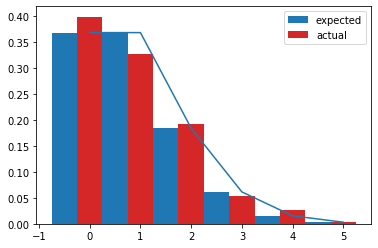

---- Sample data ----
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.4680931467365297)
Levene: LeveneResult(statistic=0.0026177689246286873, pvalue=0.960202309891221)


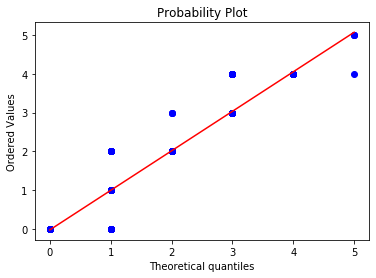

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.0800542831420898; expected: 1; difference: 0.08005428314208984
difference between std and mean :0.08493709564208984
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.00015861176692122316, pvalue=0.9901585767339428)


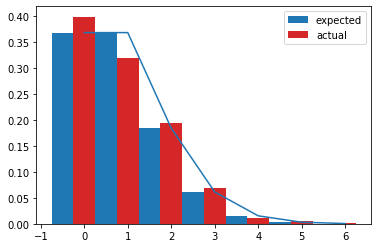

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491633936346191)
Levene: LeveneResult(statistic=0.000900554896013226, pvalue=0.9765530081793911)


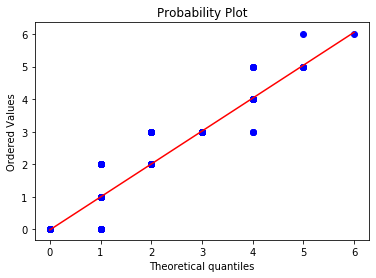

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 1.4533619284629822; expected: 1; difference: 0.4533619284629822
difference between std and mean :0.4560474753379822
MWU: MannwhitneyuResult(statistic=36.0, pvalue=0.36189765707468813)
Levene: LeveneResult(statistic=0.004771591263543373, pvalue=0.9457845063790485)


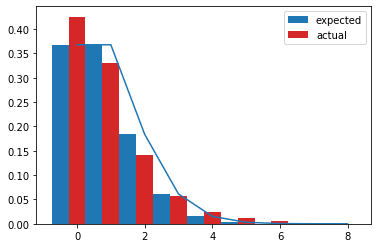

---- Sample data ----
MWU: MannwhitneyuResult(statistic=35.0, pvalue=0.3293391219268744)
Levene: LeveneResult(statistic=0.005058229527530055, pvalue=0.944182672325159)


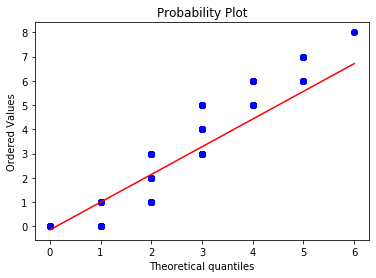

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 1.653562307357788; expected: 1; difference: 0.6535623073577881
difference between std and mean :0.6550271511077881
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)
Levene: LeveneResult(statistic=0.006071827878453775, pvalue=0.9387498232568967)


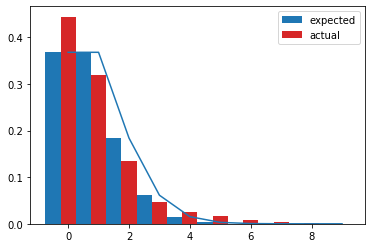

---- Sample data ----
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2599472581779684)
Levene: LeveneResult(statistic=0.005653179349584034, pvalue=0.9408947639821899)


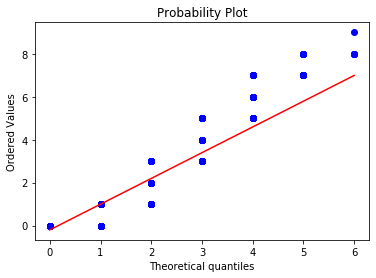

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.6763299368321896; expected: 1; difference: 0.6763299368321896
difference between std and mean :0.6771233938634396
MWU: MannwhitneyuResult(statistic=62.0, pvalue=0.12953519666662766)
Levene: LeveneResult(statistic=0.0004172079154968353, pvalue=0.9838726771181048)


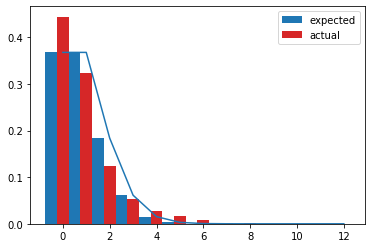

---- Sample data ----
MWU: MannwhitneyuResult(statistic=61.5, pvalue=0.12338916674958739)
Levene: LeveneResult(statistic=0.00043143027718795, pvalue=0.983600135909863)


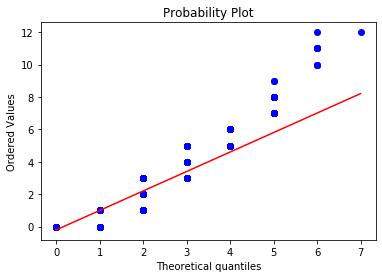

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 1.7086179815232754; expected: 1; difference: 0.7086179815232754
difference between std and mean :0.7090452276170254
MWU: MannwhitneyuResult(statistic=94.0, pvalue=0.10330788479137654)
Levene: LeveneResult(statistic=1.4507775200259583e-05, pvalue=0.9969861548562161)


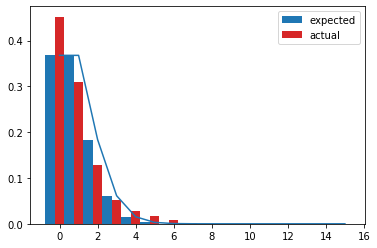

---- Sample data ----
MWU: MannwhitneyuResult(statistic=90.0, pvalue=0.07644378150913428)
Levene: LeveneResult(statistic=1.4768241868685592e-05, pvalue=0.9969592206748553)


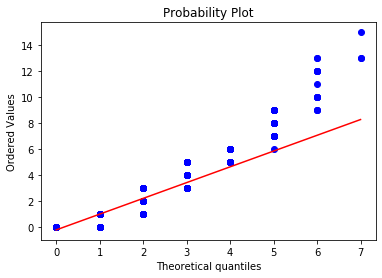

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 1.7924956751521677; expected: 1; difference: 0.7924956751521677
difference between std and mean :0.7927245569881052
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.05501505396695189)
Levene: LeveneResult(statistic=4.914140055343193e-06, pvalue=0.9982442180563779)


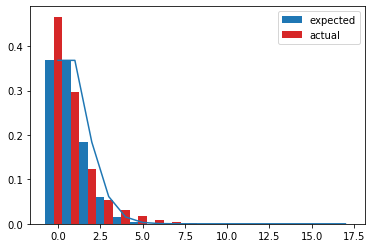

---- Sample data ----
MWU: MannwhitneyuResult(statistic=107.5, pvalue=0.042040139962551085)
Levene: LeveneResult(statistic=4.927649485484112e-06, pvalue=0.9982418063126194)


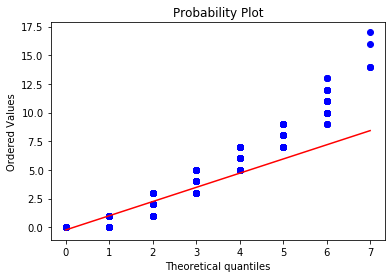

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 1.9096526950597763; expected: 1; difference: 0.9096526950597763
difference between std and mean :0.9097747653722763
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.02196446760514372)
Levene: LeveneResult(statistic=5.107163186348576e-06, pvalue=0.99820933641301)


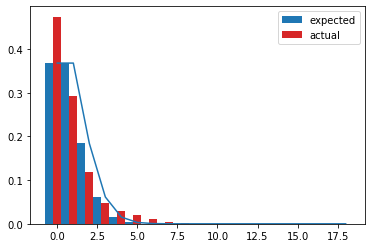

---- Sample data ----
MWU: MannwhitneyuResult(statistic=109.0, pvalue=0.01793176870746425)
Levene: LeveneResult(statistic=5.115593625332899e-06, pvalue=0.9982078590923148)


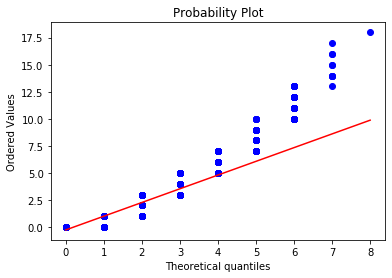

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 2.090930934515199; expected: 1; difference: 1.0909309345151992
difference between std and mean :1.0909957843687148
MWU: MannwhitneyuResult(statistic=127.0, pvalue=0.009650304089253232)
Levene: LeveneResult(statistic=4.240832706423378e-06, pvalue=0.9983671313186832)


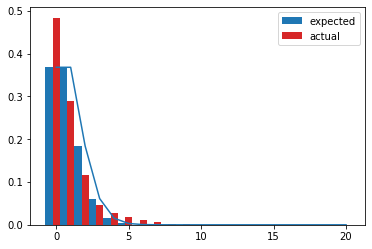

---- Sample data ----
MWU: MannwhitneyuResult(statistic=124.0, pvalue=0.007113587015417199)
Levene: LeveneResult(statistic=4.235796045278563e-06, pvalue=0.9983681012505425)


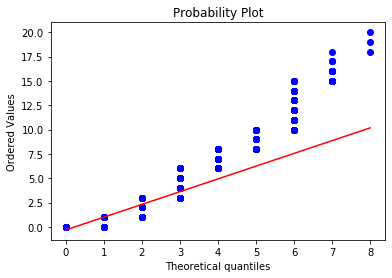

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 2.2523803699150444; expected: 1; difference: 1.2523803699150444
difference between std and mean :1.252414702190435
MWU: MannwhitneyuResult(statistic=133.0, pvalue=0.005434700476586038)
Levene: LeveneResult(statistic=1.5253300233205283e-06, pvalue=0.9990204265286203)


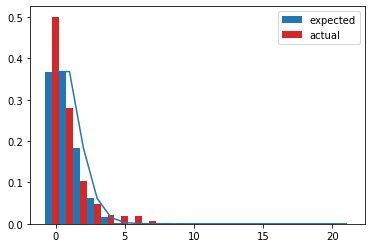

---- Sample data ----
MWU: MannwhitneyuResult(statistic=136.0, pvalue=0.0061767668254195255)
Levene: LeveneResult(statistic=1.5252402595492099e-06, pvalue=0.9990204553516515)


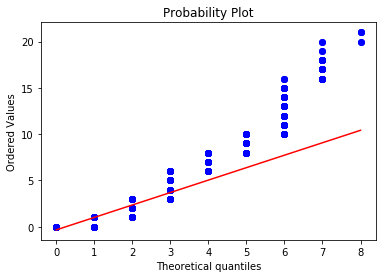

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 2.389916419654582; expected: 1; difference: 1.3899164196545821
difference between std and mean :1.3899345394665938
MWU: MannwhitneyuResult(statistic=197.0, pvalue=0.001931078555013984)
Levene: LeveneResult(statistic=3.2464562198427027e-07, pvalue=0.9995475641749737)


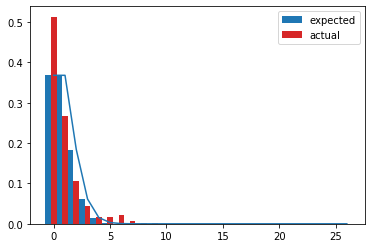

---- Sample data ----
MWU: MannwhitneyuResult(statistic=183.5, pvalue=0.0007042290906213623)
Levene: LeveneResult(statistic=3.247184465943701e-07, pvalue=0.9995475134299017)


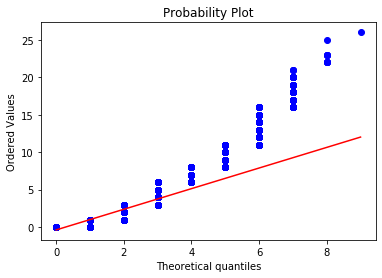

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 2.8316497801824894; expected: 1; difference: 1.8316497801824894
difference between std and mean :1.8316593169256534
MWU: MannwhitneyuResult(statistic=243.0, pvalue=0.0011322502805564737)
Levene: LeveneResult(statistic=2.6025465794149795e-07, pvalue=0.9995947085567988)


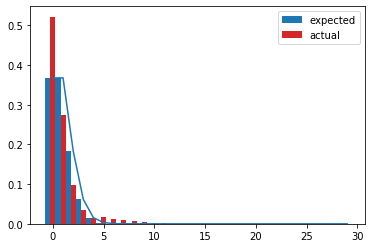

---- Sample data ----
MWU: MannwhitneyuResult(statistic=223.0, pvalue=0.00029700514156934374)
Levene: LeveneResult(statistic=2.603311574519204e-07, pvalue=0.9995946490008585)


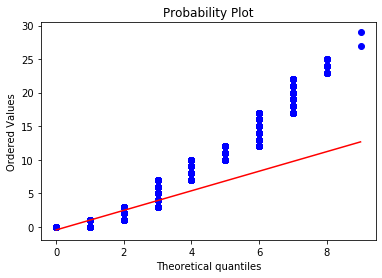

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 3.2049806117760795; expected: 1; difference: 2.2049806117760795
difference between std and mean :2.2049856185662406
MWU: MannwhitneyuResult(statistic=218.0, pvalue=4.0578098443537e-05)
Levene: LeveneResult(statistic=2.4769061167917416e-07, pvalue=0.9996045025332159)


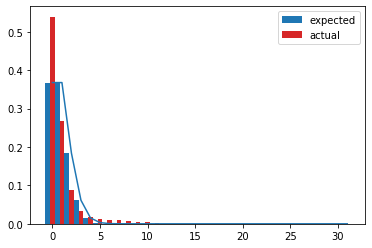

---- Sample data ----
MWU: MannwhitneyuResult(statistic=219.5, pvalue=3.276413900755645e-05)
Levene: LeveneResult(statistic=2.4770934387573655e-07, pvalue=0.9996044875802832)


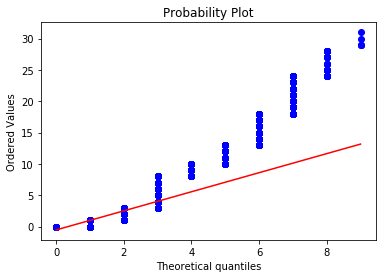

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 3.2432062625816225; expected: 1; difference: 2.2432062625816225
difference between std and mean :2.2432088851859926
MWU: MannwhitneyuResult(statistic=243.0, pvalue=7.307187427838922e-06)
Levene: LeveneResult(statistic=1.6384609864396004e-07, pvalue=0.9996782181958629)


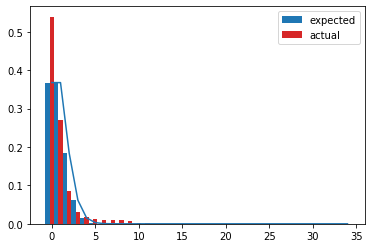

---- Sample data ----
MWU: MannwhitneyuResult(statistic=244.0, pvalue=4.834476997668592e-06)
Levene: LeveneResult(statistic=1.6385166720824216e-07, pvalue=0.9996782127248569)


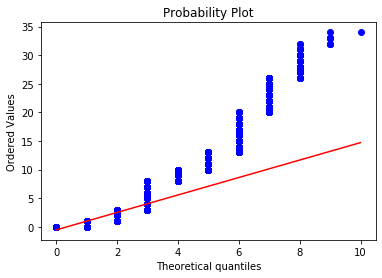

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 3.267494261262921; expected: 1; difference: 2.267494261262921
difference between std and mean :2.267495632169751
MWU: MannwhitneyuResult(statistic=304.0, pvalue=3.3312412225741657e-07)
Levene: LeveneResult(statistic=3.398543002521782e-08, pvalue=0.9998533678188493)


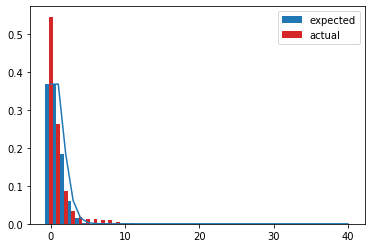

---- Sample data ----
MWU: MannwhitneyuResult(statistic=304.0, pvalue=1.723281850739646e-07)
Levene: LeveneResult(statistic=3.39851675453783e-08, pvalue=0.9998533683745047)


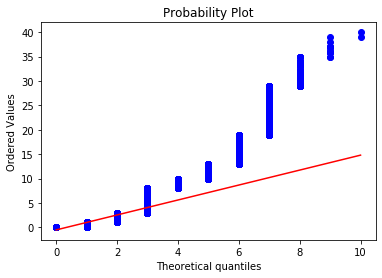

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 3.3934298753733283; expected: 1; difference: 2.3934298753733283
difference between std and mean :2.3934305906290656
MWU: MannwhitneyuResult(statistic=364.0, pvalue=1.0970978184854034e-08)
Levene: LeveneResult(statistic=1.2188441247364735e-08, pvalue=0.9999121515776166)


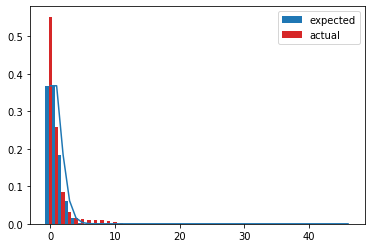

---- Sample data ----
MWU: MannwhitneyuResult(statistic=358.0, pvalue=2.9161148417058448e-09)
Levene: LeveneResult(statistic=1.2188213614221197e-08, pvalue=0.9999121523874183)


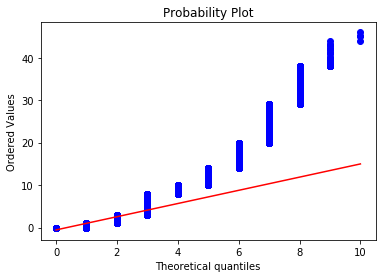

In [302]:
for N in Ns:
    print(N)
    analize_result(occs[N],N,plot=True)
    analize_result_2(occs[N],plot=True)

### Levin with lambda = 4 from N=2ˆ10 up to 2ˆ26.

In [247]:
Ns2 = [2**i for i in range(10,26)]
occs2 = get_amounts_for_ns(Ns2,lamb=4)

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 4.6437835693359375; expected: 4; difference: 0.6437835693359375
difference between std and mean :0.6711273193359375
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.48847761269707995)
Levene: LeveneResult(statistic=0.327983841646747, pvalue=0.5726558592047031)


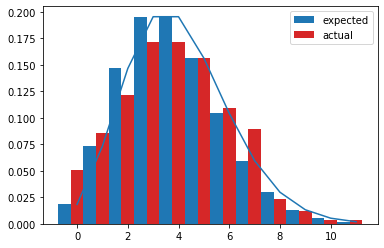

---- Sample data ----
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.024343081840110616)
Levene: LeveneResult(statistic=0.44909220706554237, pvalue=0.5097401909525054)


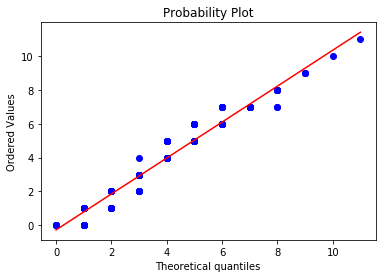

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 4.175537109375; expected: 4; difference: 0.175537109375
difference between std and mean :0.191162109375
MWU: MannwhitneyuResult(statistic=71.0, pvalue=0.48848262430702205)
Levene: LeveneResult(statistic=0.01629730908047247, pvalue=0.8995770539529728)


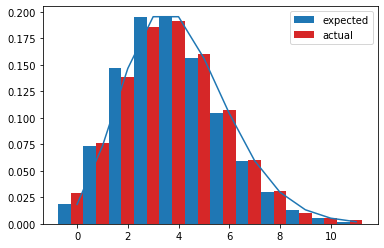

---- Sample data ----
MWU: MannwhitneyuResult(statistic=43.5, pvalue=0.05161601047428278)
Levene: LeveneResult(statistic=0.3058439886724447, pvalue=0.5858181708527694)


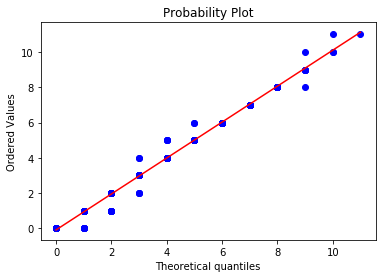

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 5.420821189880371; expected: 4; difference: 1.420821189880371
difference between std and mean :1.429610252380371
MWU: MannwhitneyuResult(statistic=79.0, pvalue=0.39880010979147085)
Levene: LeveneResult(statistic=0.3283053871395948, pvalue=0.5719884876879613)


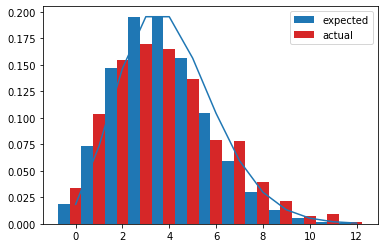

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.5, pvalue=0.0413760359942225)
Levene: LeveneResult(statistic=0.3542147543389587, pvalue=0.5573075473825496)


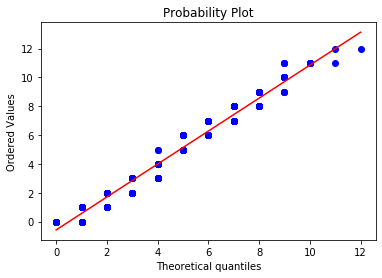

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 6.01169490814209; expected: 4; difference: 2.01169490814209
difference between std and mean :2.01657772064209
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.3825841746929821)
Levene: LeveneResult(statistic=0.36363397254691215, pvalue=0.5517192992964484)


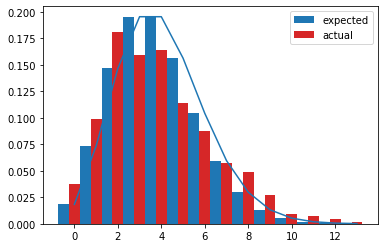

---- Sample data ----
MWU: MannwhitneyuResult(statistic=55.0, pvalue=0.02453894205354802)
Levene: LeveneResult(statistic=0.2867930900174141, pvalue=0.5968345802966912)


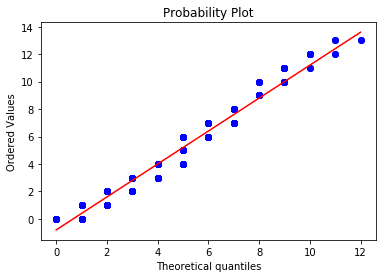

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 6.552971303462982; expected: 4; difference: 2.552971303462982
difference between std and mean :2.555656850337982
MWU: MannwhitneyuResult(statistic=140.0, pvalue=0.24816559526272136)
Levene: LeveneResult(statistic=0.0334727272006722, pvalue=0.8559195399670076)


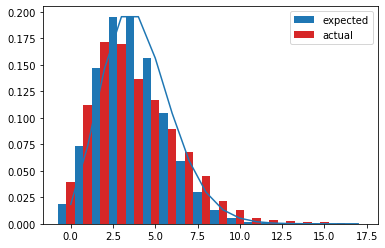

---- Sample data ----
MWU: MannwhitneyuResult(statistic=79.0, pvalue=0.003911781760526553)
Levene: LeveneResult(statistic=0.034450076839368515, pvalue=0.8538555950331881)


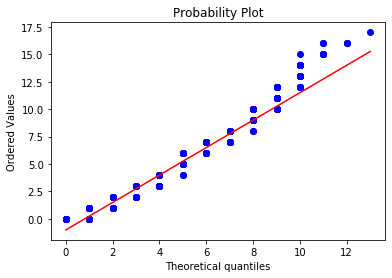

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 6.710447072982788; expected: 4; difference: 2.710447072982788
difference between std and mean :2.711911916732788
MWU: MannwhitneyuResult(statistic=181.0, pvalue=0.16322914811684786)
Levene: LeveneResult(statistic=0.007423932282611145, pvalue=0.9317673060743435)


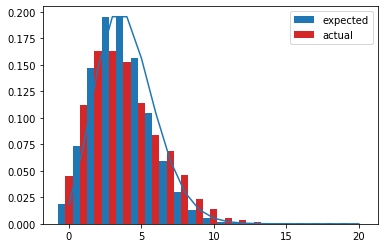

---- Sample data ----
MWU: MannwhitneyuResult(statistic=97.5, pvalue=0.0008428183653569292)
Levene: LeveneResult(statistic=0.005854695318871783, pvalue=0.93939004320189)


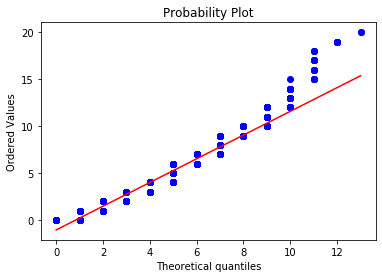

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 7.15130552276969; expected: 4; difference: 3.1513055227696896
difference between std and mean :3.1520989798009396
MWU: MannwhitneyuResult(statistic=236.0, pvalue=0.07013877596045084)
Levene: LeveneResult(statistic=0.0015973110399356849, pvalue=0.968285708815182)


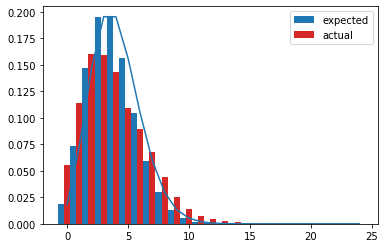

---- Sample data ----
MWU: MannwhitneyuResult(statistic=129.5, pvalue=0.00015125854809649292)
Levene: LeveneResult(statistic=0.000928042596762408, pvalue=0.9758234870641166)


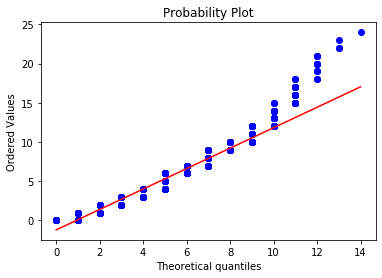

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 7.796081360429525; expected: 4; difference: 3.7960813604295254
difference between std and mean :3.7965086065232754
MWU: MannwhitneyuResult(statistic=280.0, pvalue=0.07306132592251174)
Levene: LeveneResult(statistic=0.0009283416111118242, pvalue=0.9758099001289736)


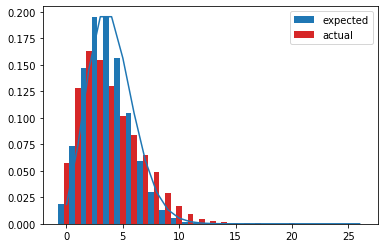

---- Sample data ----
MWU: MannwhitneyuResult(statistic=156.0, pvalue=0.00011657115970219494)
Levene: LeveneResult(statistic=0.0005063670536528588, pvalue=0.9821331660654553)


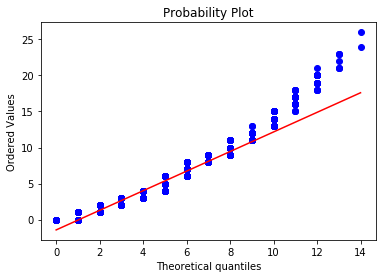

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 8.595779366558418; expected: 4; difference: 4.595779366558418
difference between std and mean :4.596008248394355
MWU: MannwhitneyuResult(statistic=335.0, pvalue=0.04523622461013404)
Levene: LeveneResult(statistic=0.00047624589776486297, pvalue=0.9826640057532796)


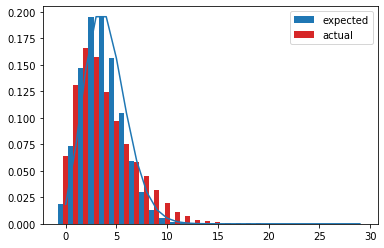

---- Sample data ----
MWU: MannwhitneyuResult(statistic=189.0, pvalue=3.675857295192563e-05)
Levene: LeveneResult(statistic=0.0002529614129042437, pvalue=0.987364957441672)


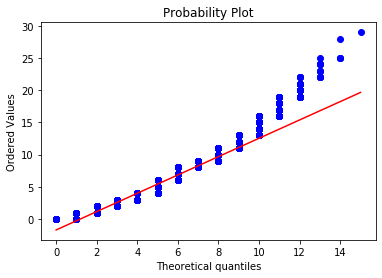

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 9.379974350333214; expected: 4; difference: 5.379974350333214
difference between std and mean :5.380096420645714
MWU: MannwhitneyuResult(statistic=356.0, pvalue=0.018397025770230738)
Levene: LeveneResult(statistic=0.0002600527018985562, pvalue=0.9871855341317218)


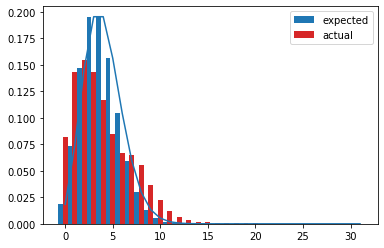

---- Sample data ----
MWU: MannwhitneyuResult(statistic=195.5, pvalue=6.517570104231694e-06)
Levene: LeveneResult(statistic=0.0001378402695819078, pvalue=0.9906703174057327)


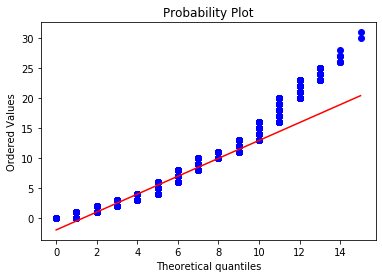

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 9.749706264105042; expected: 4; difference: 5.749706264105042
difference between std and mean :5.749771113958557
MWU: MannwhitneyuResult(statistic=438.0, pvalue=0.009147756996618791)
Levene: LeveneResult(statistic=7.800057671880956e-05, pvalue=0.9929784621235029)


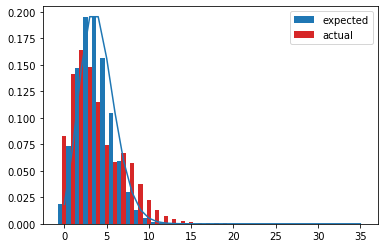

---- Sample data ----
MWU: MannwhitneyuResult(statistic=244.5, pvalue=1.3346413290221673e-06)
Levene: LeveneResult(statistic=4.223658205591978e-05, pvalue=0.9948330965678728)


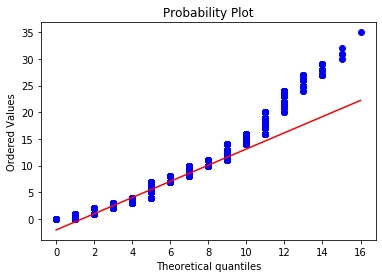

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 11.255565642131844; expected: 4; difference: 7.2555656421318435
difference between std and mean :7.255599974407234
MWU: MannwhitneyuResult(statistic=374.0, pvalue=0.0025900225820523807)
Levene: LeveneResult(statistic=0.00025625808247218526, pvalue=0.9872748352673311)


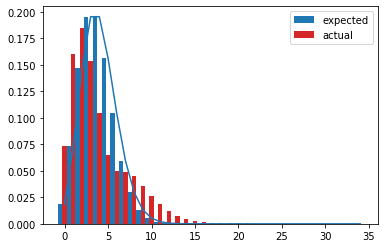

---- Sample data ----
MWU: MannwhitneyuResult(statistic=202.0, pvalue=3.8245240884436716e-07)
Levene: LeveneResult(statistic=0.00013965408873498186, pvalue=0.9906057953107278)


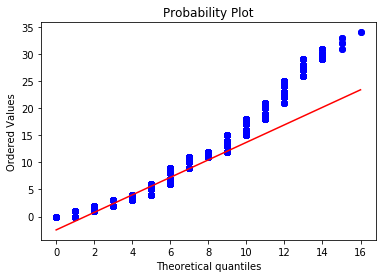

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 12.630023002296188; expected: 4; difference: 8.630023002296188
difference between std and mean :8.6300411221082
MWU: MannwhitneyuResult(statistic=449.0, pvalue=0.00037213806020204235)
Levene: LeveneResult(statistic=9.388791724216553e-05, pvalue=0.9922936966644915)


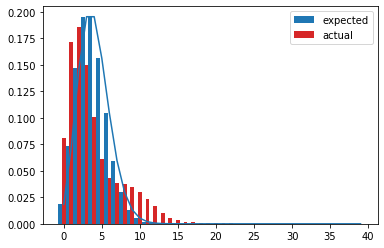

---- Sample data ----
MWU: MannwhitneyuResult(statistic=242.0, pvalue=1.7758901385353462e-08)
Levene: LeveneResult(statistic=5.224293837020388e-05, pvalue=0.994251452848497)


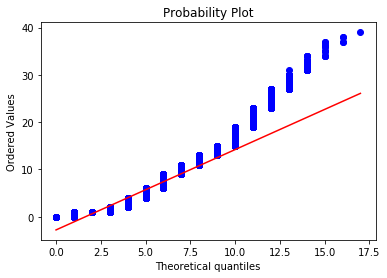

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 12.872947692780144; expected: 4; difference: 8.872947692780144
difference between std and mean :8.872957229523308
MWU: MannwhitneyuResult(statistic=511.0, pvalue=6.957572736973741e-05)
Levene: LeveneResult(statistic=5.518898128109315e-05, pvalue=0.9940898329869352)


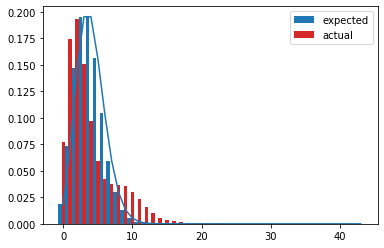

---- Sample data ----
MWU: MannwhitneyuResult(statistic=274.5, pvalue=1.279975247760713e-09)
Levene: LeveneResult(statistic=3.115318640698145e-05, pvalue=0.9955595543195428)


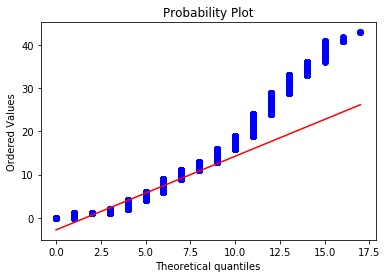

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 12.94379973409053; expected: 4; difference: 8.94379973409053
difference between std and mean :8.943804740880692
MWU: MannwhitneyuResult(statistic=645.0, pvalue=1.5409638028869078e-05)
Levene: LeveneResult(statistic=1.4974417710380703e-05, pvalue=0.9969203166619995)


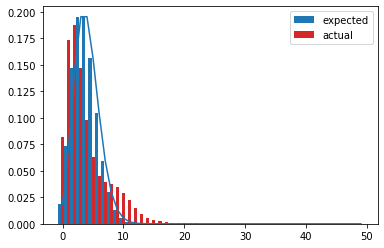

---- Sample data ----
MWU: MannwhitneyuResult(statistic=346.5, pvalue=5.5443980981032376e-11)
Levene: LeveneResult(statistic=8.514436490265112e-06, pvalue=0.9976777470724826)


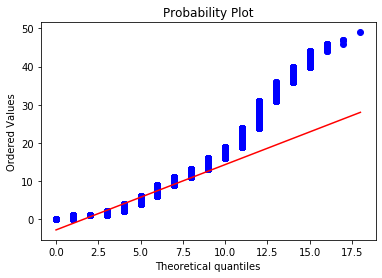

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 13.631802320473465; expected: 4; difference: 9.631802320473465
difference between std and mean :9.631804943077835
MWU: MannwhitneyuResult(statistic=691.0, pvalue=4.5981178633439797e-07)
Levene: LeveneResult(statistic=7.256936032761725e-06, pvalue=0.9978555749007572)


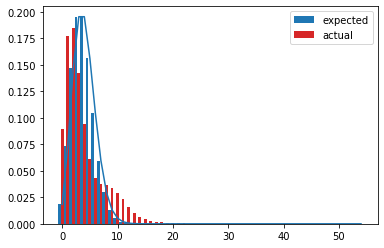

---- Sample data ----
MWU: MannwhitneyuResult(statistic=372.0, pvalue=9.328254302568977e-13)
Levene: LeveneResult(statistic=4.152812740695589e-06, pvalue=0.9983777953762346)


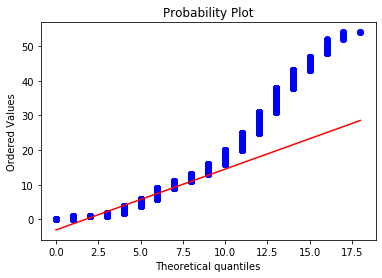

In [303]:
for N in Ns2:
    print(N)
    analize_result(occs2[N],N,plot=True,l=4)
    analize_result_2(occs2[N],plot=True,l=4)

### Levin with lambda = 32 from N=2ˆ10 up to 2ˆ26.

In [268]:
Ns3 = [2**i for i in range(10,26)]
occs3 = get_amounts_for_ns(Ns3,lamb=32)

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 9.109375; expected: 32; difference: 22.890625
difference between std and mean :22.765625
MWU: MannwhitneyuResult(statistic=367.0, pvalue=2.888332943803969e-05)
Levene: LeveneResult(statistic=0.16028251336312102, pvalue=0.6900197100179897)


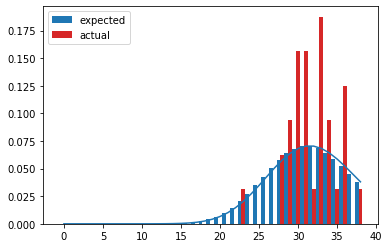

---- Sample data ----
MWU: MannwhitneyuResult(statistic=637.0, pvalue=0.03692604286208725)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


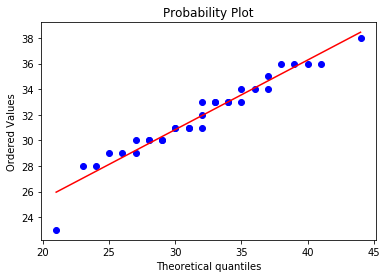

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 7.040771484375; expected: 32; difference: 24.959228515625
difference between std and mean :24.881103515625
MWU: MannwhitneyuResult(statistic=408.0, pvalue=0.00016346309968823697)
Levene: LeveneResult(statistic=0.186532574479709, pvalue=0.6670411826445173)


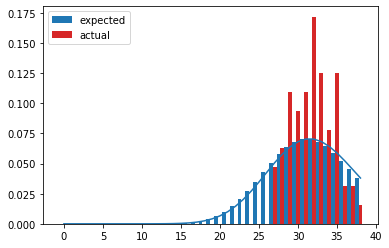

---- Sample data ----
MWU: MannwhitneyuResult(statistic=648.5, pvalue=0.06556692682609641)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


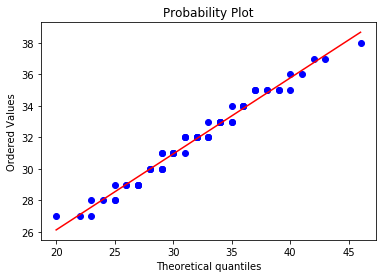

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 12.591552734375; expected: 32; difference: 19.408447265625
difference between std and mean :19.361572265625
MWU: MannwhitneyuResult(statistic=558.0, pvalue=0.004038962090780901)
Levene: LeveneResult(statistic=0.11328217219095629, pvalue=0.7373192326310609)


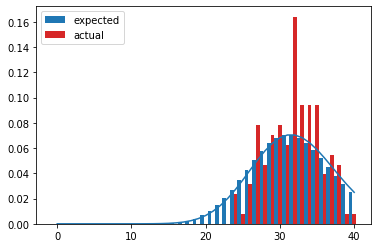

---- Sample data ----
MWU: MannwhitneyuResult(statistic=644.0, pvalue=0.011847595771103829)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


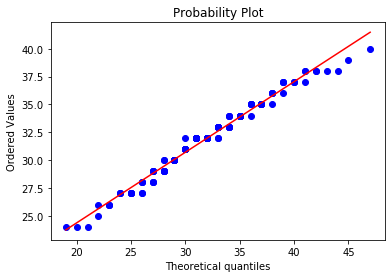

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 22.221908569335938; expected: 32; difference: 9.778091430664062
difference between std and mean :9.750747680664062
MWU: MannwhitneyuResult(statistic=777.0, pvalue=0.02814848918561615)
Levene: LeveneResult(statistic=0.0782114312054431, pvalue=0.7803922969250103)


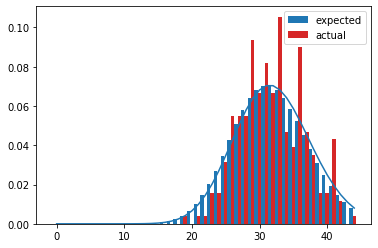

---- Sample data ----
MWU: MannwhitneyuResult(statistic=630.5, pvalue=0.00012093045191728113)
Levene: LeveneResult(statistic=0.00042295039945316326, pvalue=0.9836386153261997)


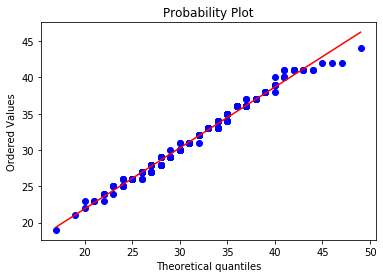

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 26.843505859375; expected: 32; difference: 5.156494140625
difference between std and mean :5.140869140625
MWU: MannwhitneyuResult(statistic=1012.0, pvalue=0.09000206721072934)
Levene: LeveneResult(statistic=0.007939759851067783, pvalue=0.9291838308550879)


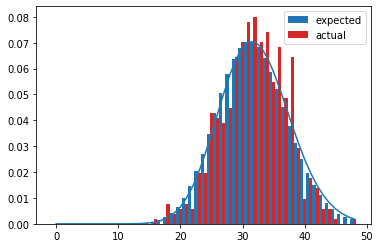

---- Sample data ----
MWU: MannwhitneyuResult(statistic=654.5, pvalue=4.295556220112678e-06)
Levene: LeveneResult(statistic=0.004269227414707818, pvalue=0.9480397048250743)


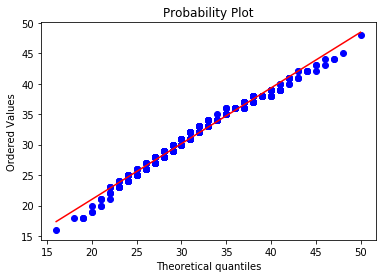

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 26.01261806488037; expected: 32; difference: 5.987381935119629
difference between std and mean :5.978592872619629
MWU: MannwhitneyuResult(statistic=1081.0, pvalue=0.12211038547332753)
Levene: LeveneResult(statistic=0.004874878395640049, pvalue=0.9444789403546455)


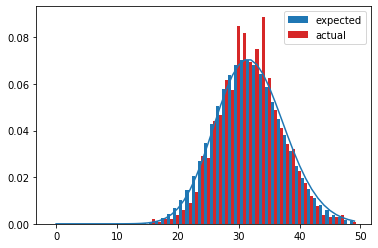

---- Sample data ----
MWU: MannwhitneyuResult(statistic=620.0, pvalue=3.9878487247155395e-07)
Levene: LeveneResult(statistic=0.00371790653478979, pvalue=0.9515035850969034)


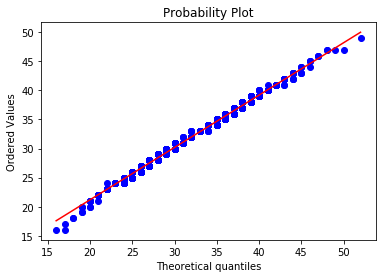

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 24.02146053314209; expected: 32; difference: 7.97853946685791
difference between std and mean :7.97365665435791
MWU: MannwhitneyuResult(statistic=1127.0, pvalue=0.12291144219612765)
Levene: LeveneResult(statistic=0.007566551125231048, pvalue=0.9308566430445193)


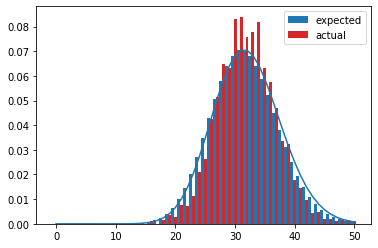

---- Sample data ----
MWU: MannwhitneyuResult(statistic=648.0, pvalue=4.2903177753805964e-07)
Levene: LeveneResult(statistic=0.0019437922564549653, pvalue=0.9649218094187682)


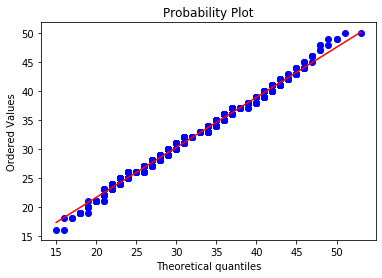

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 23.899162709712982; expected: 32; difference: 8.100837290287018
difference between std and mean :8.098151743412018
MWU: MannwhitneyuResult(statistic=1177.0, pvalue=0.12786181022667437)
Levene: LeveneResult(statistic=0.008207046648660987, pvalue=0.9279938554068192)


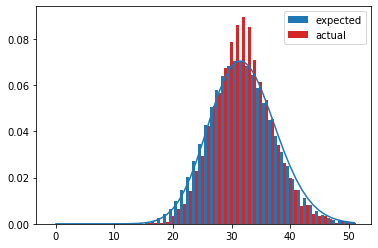

---- Sample data ----
MWU: MannwhitneyuResult(statistic=636.5, pvalue=9.800273024154187e-08)
Levene: LeveneResult(statistic=0.0010858236581561555, pvalue=0.9737773896177905)


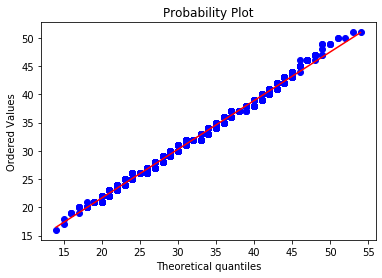

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 30.402585744857788; expected: 32; difference: 1.597414255142212
difference between std and mean :1.595949411392212
MWU: MannwhitneyuResult(statistic=1593.0, pvalue=0.21406395182500243)
Levene: LeveneResult(statistic=0.00016102803566117046, pvalue=0.9898971690691633)


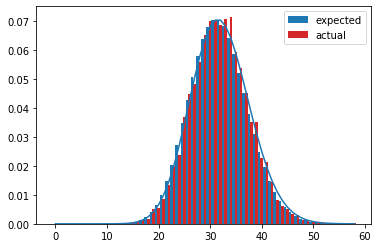

---- Sample data ----
MWU: MannwhitneyuResult(statistic=777.5, pvalue=4.1778908452512705e-09)
Levene: LeveneResult(statistic=0.0006433432483013984, pvalue=0.9798080388815319)


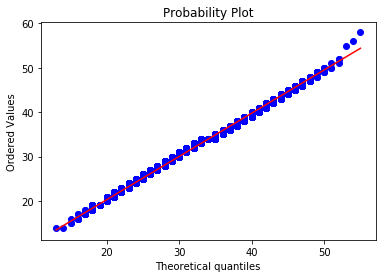

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 36.04132017120719; expected: 32; difference: 4.04132017120719
difference between std and mean :4.04211362823844
MWU: MannwhitneyuResult(statistic=1947.0, pvalue=0.42831720306024323)
Levene: LeveneResult(statistic=0.000935224118242488, pvalue=0.9756525158878957)


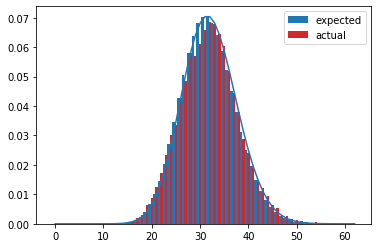

---- Sample data ----
MWU: MannwhitneyuResult(statistic=744.0, pvalue=1.495440013592817e-11)
Levene: LeveneResult(statistic=0.0009903173633123003, pvalue=0.9749458646419138)


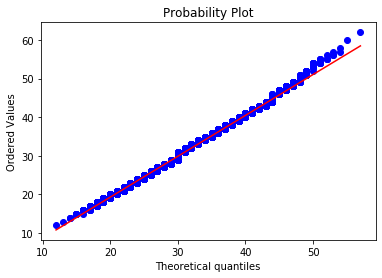

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 36.777953919023275; expected: 32; difference: 4.777953919023275
difference between std and mean :4.778381165117025
MWU: MannwhitneyuResult(statistic=2091.0, pvalue=0.4610365540447827)
Levene: LeveneResult(statistic=0.0014696530233622859, pvalue=0.9694794716351689)


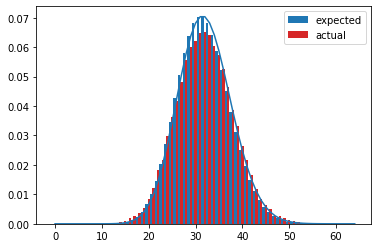

---- Sample data ----
MWU: MannwhitneyuResult(statistic=727.0, pvalue=1.6187906173298242e-12)
Levene: LeveneResult(statistic=0.0009247258501676338, pvalue=0.9757879877289304)


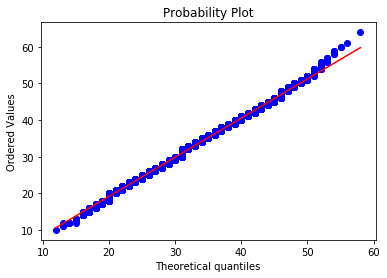

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 32.00819391733967; expected: 32; difference: 0.008193917339667678
difference between std and mean :0.008422799175605178
MWU: MannwhitneyuResult(statistic=1859.0, pvalue=0.2707569930776443)
Levene: LeveneResult(statistic=8.590311766196191e-07, pvalue=0.9992619787295945)


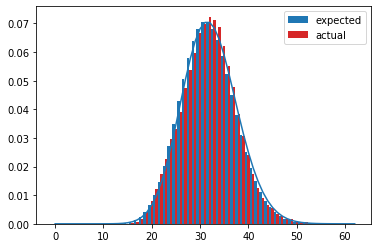

---- Sample data ----
MWU: MannwhitneyuResult(statistic=821.0, pvalue=2.2725288199185701e-10)
Levene: LeveneResult(statistic=0.00030990537550494487, pvalue=0.9859829565405427)


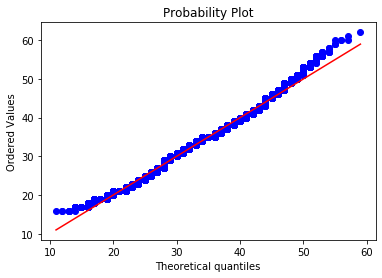

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 41.036910995841026; expected: 32; difference: 9.036910995841026
difference between std and mean :9.037033066153526
MWU: MannwhitneyuResult(statistic=2021.0, pvalue=0.23812770431805402)
Levene: LeveneResult(statistic=0.004292786338064631, pvalue=0.9478611430774805)


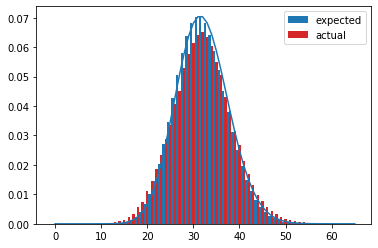

---- Sample data ----
MWU: MannwhitneyuResult(statistic=617.0, pvalue=1.8917538897168697e-14)
Levene: LeveneResult(statistic=0.0015903878640976211, pvalue=0.9682502415357892)


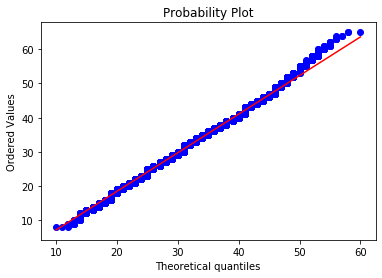

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 48.292713161077714; expected: 32; difference: 16.292713161077714
difference between std and mean :16.29277801093123
MWU: MannwhitneyuResult(statistic=2266.0, pvalue=0.09669651653324096)
Levene: LeveneResult(statistic=0.004950664625852556, pvalue=0.9440053573538428)


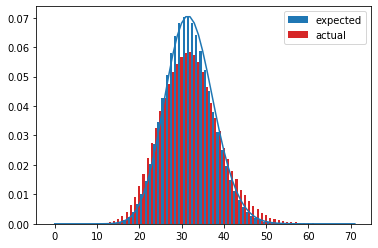

---- Sample data ----
MWU: MannwhitneyuResult(statistic=630.0, pvalue=5.868406301933317e-17)
Levene: LeveneResult(statistic=0.0012400404148157544, pvalue=0.9719583862316723)


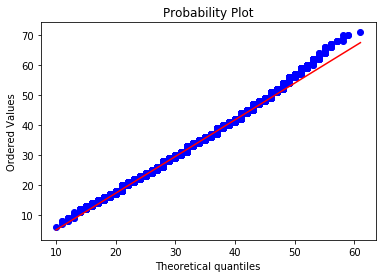

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 51.42560958744433; expected: 32; difference: 19.425609587444328
difference between std and mean :19.425643919719718
MWU: MannwhitneyuResult(statistic=2472.0, pvalue=0.06286511083163183)
Levene: LeveneResult(statistic=0.004315243825175546, pvalue=0.9477116934957257)


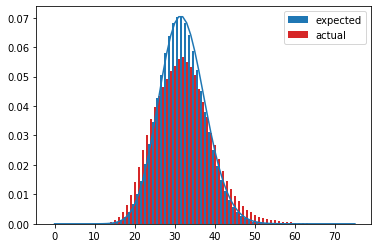

---- Sample data ----
MWU: MannwhitneyuResult(statistic=671.5, pvalue=2.8634088700385e-18)
Levene: LeveneResult(statistic=0.0009717842583500464, pvalue=0.9751726499058777)


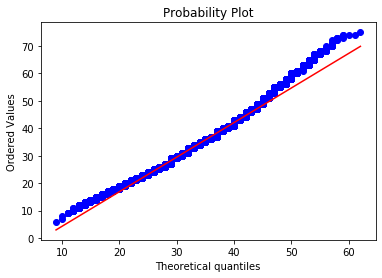

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 52.71373653379031; expected: 32; difference: 20.71373653379031
difference between std and mean :20.713754653602322
MWU: MannwhitneyuResult(statistic=2807.0, pvalue=0.03409822365630973)
Levene: LeveneResult(statistic=0.0018910064081134232, pvalue=0.9653679136292999)


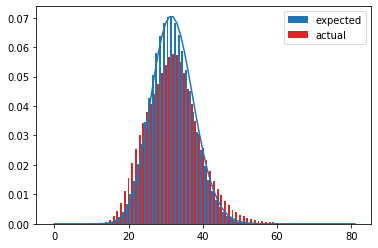

---- Sample data ----
MWU: MannwhitneyuResult(statistic=780.5, pvalue=1.288416299756937e-19)
Levene: LeveneResult(statistic=0.0004096356075235029, pvalue=0.9838772590559903)


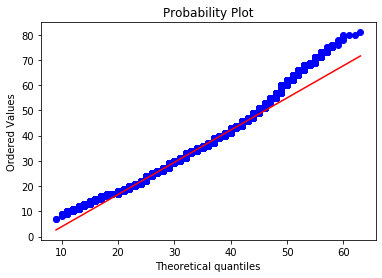

In [304]:
for N in Ns3:
    print(N)
    analize_result(occs3[N],N,plot=True,l=32)
    analize_result_2(occs3[N],plot=True,l=32)

### Champernowne with lambda = 4 from N=2ˆ10 up to 2ˆ26

In [310]:
Ns_c4 = [2**i for i in range(10,26)]
occs_c4 = get_amounts_for_ns(Ns2,lamb=4,use_seq='champernowne')

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 3.8312835693359375; expected: 4; difference: 0.1687164306640625
difference between std and mean :0.1413726806640625
MWU: MannwhitneyuResult(statistic=83.0, pvalue=0.4795364004210436)
Levene: LeveneResult(statistic=0.06057092104351643, pvalue=0.807688527974126)


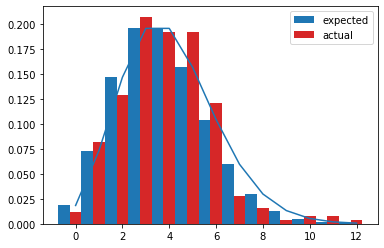

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.03900358165636666)
Levene: LeveneResult(statistic=0.0531461478396669, pvalue=0.8196302824323345)


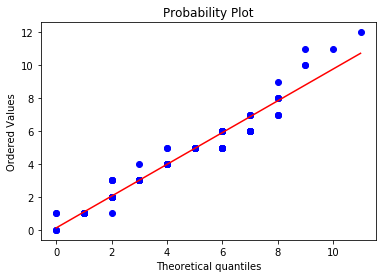

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 5.706787109375; expected: 4; difference: 1.706787109375
difference between std and mean :1.722412109375
MWU: MannwhitneyuResult(statistic=130.0, pvalue=0.31475003399766704)
Levene: LeveneResult(statistic=0.01946761667567792, pvalue=0.8899086644109994)


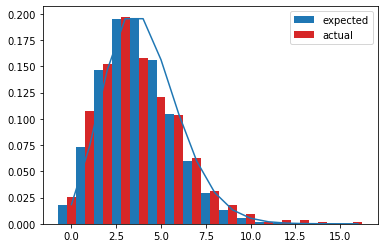

---- Sample data ----
MWU: MannwhitneyuResult(statistic=80.5, pvalue=0.012627807069794987)
Levene: LeveneResult(statistic=0.03766970826211889, pvalue=0.8473347326519634)


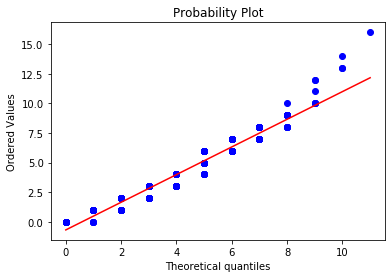

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 8.006758689880371; expected: 4; difference: 4.006758689880371
difference between std and mean :4.015547752380371
MWU: MannwhitneyuResult(statistic=191.0, pvalue=0.23279770605455818)
Levene: LeveneResult(statistic=0.017646232628812004, pvalue=0.8949866422193873)


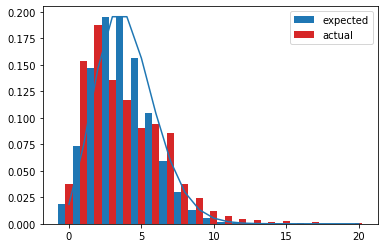

---- Sample data ----
MWU: MannwhitneyuResult(statistic=109.0, pvalue=0.002028743032707537)
Levene: LeveneResult(statistic=0.01178086667602384, pvalue=0.9141102460314071)


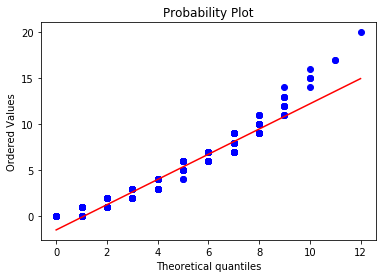

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 9.10935115814209; expected: 4; difference: 5.10935115814209
difference between std and mean :5.11423397064209
MWU: MannwhitneyuResult(statistic=122.0, pvalue=0.22428069143091445)
Levene: LeveneResult(statistic=0.19958706442483265, pvalue=0.6580633674272556)


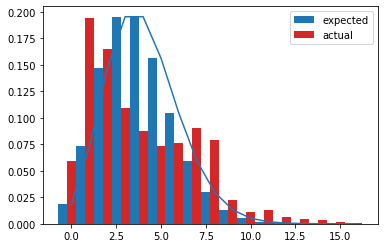

---- Sample data ----
MWU: MannwhitneyuResult(statistic=68.5, pvalue=0.004217964302237853)
Levene: LeveneResult(statistic=0.1259032143711013, pvalue=0.7250460634384241)


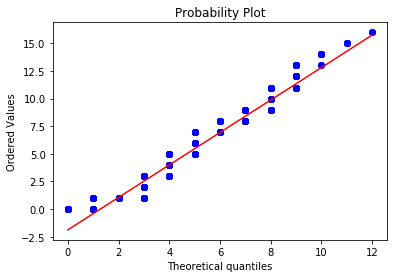

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 9.672111928462982; expected: 4; difference: 5.672111928462982
difference between std and mean :5.674797475337982
MWU: MannwhitneyuResult(statistic=171.0, pvalue=0.10882871899210733)
Levene: LeveneResult(statistic=0.03023552937873271, pvalue=0.8628339305273)


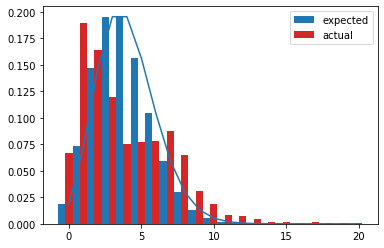

---- Sample data ----
MWU: MannwhitneyuResult(statistic=92.0, pvalue=0.0005398181249765872)
Levene: LeveneResult(statistic=0.017801213960055826, pvalue=0.8945292856049352)


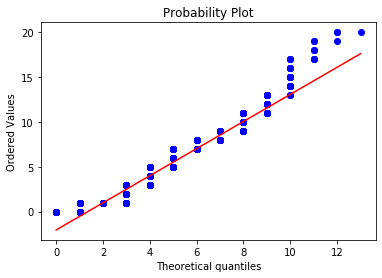

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 10.803464651107788; expected: 4; difference: 6.803464651107788
difference between std and mean :6.804929494857788
MWU: MannwhitneyuResult(statistic=234.0, pvalue=0.029082236383509822)
Levene: LeveneResult(statistic=0.007216590878810906, pvalue=0.9326399719414831)


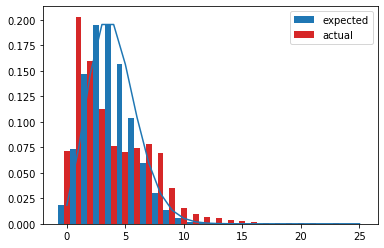

---- Sample data ----
MWU: MannwhitneyuResult(statistic=125.0, pvalue=3.331137878585164e-05)
Levene: LeveneResult(statistic=0.0037851307393466267, pvalue=0.9511876408597415)


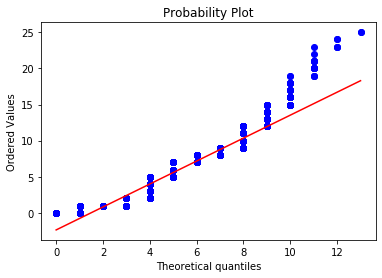

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 11.84649595245719; expected: 4; difference: 7.84649595245719
difference between std and mean :7.84728940948844
MWU: MannwhitneyuResult(statistic=305.0, pvalue=0.00687042756425226)
Levene: LeveneResult(statistic=0.0019396088615250338, pvalue=0.9650179745518496)


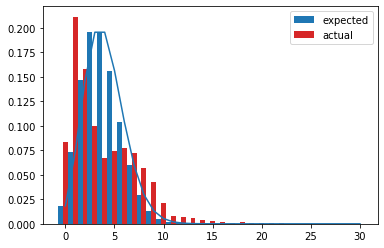

---- Sample data ----
MWU: MannwhitneyuResult(statistic=158.0, pvalue=1.627814640083226e-06)
Levene: LeveneResult(statistic=0.0010265333353761208, pvalue=0.9745468476055728)


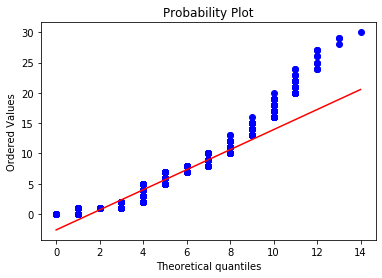

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 14.135986145585775; expected: 4; difference: 10.135986145585775
difference between std and mean :10.136413391679525
MWU: MannwhitneyuResult(statistic=386.0, pvalue=0.0006366472379299044)
Levene: LeveneResult(statistic=0.0007320914147243734, pvalue=0.9784889764245555)


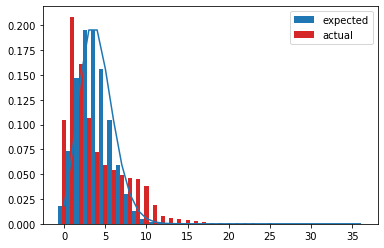

---- Sample data ----
MWU: MannwhitneyuResult(statistic=200.0, pvalue=3.3723742325548526e-08)
Levene: LeveneResult(statistic=0.00040011049180488367, pvalue=0.9840964986342984)


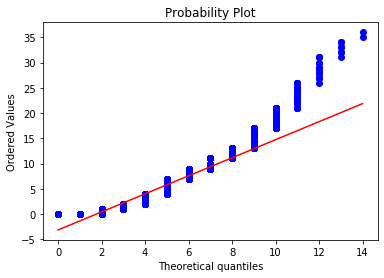

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 16.531997628277168; expected: 4; difference: 12.531997628277168
difference between std and mean :12.532226510113105
MWU: MannwhitneyuResult(statistic=468.0, pvalue=4.097310678168689e-05)
Levene: LeveneResult(statistic=0.00039489928372222685, pvalue=0.9841925506591248)


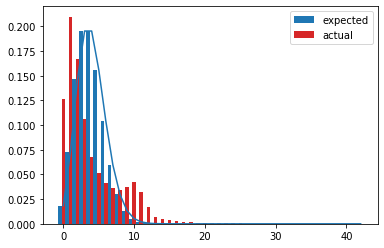

---- Sample data ----
MWU: MannwhitneyuResult(statistic=253.5, pvalue=1.0057994517976455e-09)
Levene: LeveneResult(statistic=0.0002200145758070372, pvalue=0.9882006750639799)


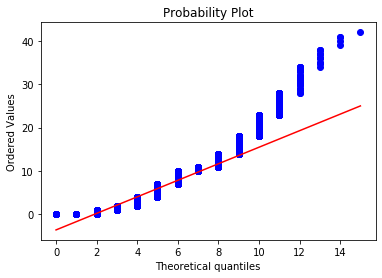

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 19.141754135489464; expected: 4; difference: 15.141754135489464
difference between std and mean :15.141876205801964
MWU: MannwhitneyuResult(statistic=642.0, pvalue=1.4058992489761387e-05)
Levene: LeveneResult(statistic=0.00016498870890067335, pvalue=0.9897777326624936)


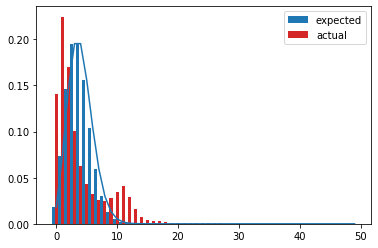

---- Sample data ----
MWU: MannwhitneyuResult(statistic=346.5, pvalue=4.326063517303224e-11)
Levene: LeveneResult(statistic=9.508241420185052e-05, pvalue=0.9922397567584207)


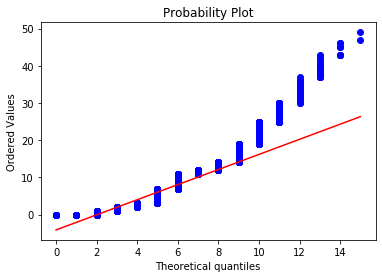

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 22.34499740180036; expected: 4; difference: 18.34499740180036
difference between std and mean :18.345062251653875
MWU: MannwhitneyuResult(statistic=761.0, pvalue=5.018460922675953e-07)
Levene: LeveneResult(statistic=6.731726167969261e-05, pvalue=0.9934682587565052)


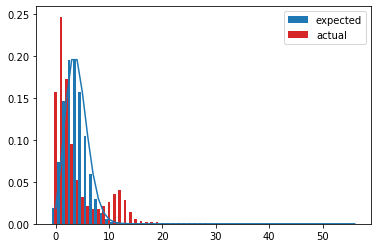

---- Sample data ----
MWU: MannwhitneyuResult(statistic=411.5, pvalue=3.977914995053687e-13)
Levene: LeveneResult(statistic=3.992593480254063e-05, pvalue=0.994969683652696)


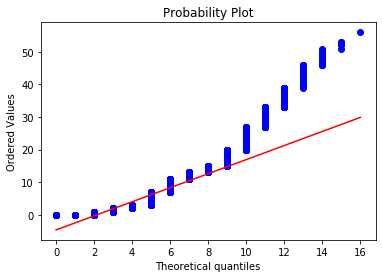

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 26.04090118290333; expected: 4; difference: 22.04090118290333
difference between std and mean :22.04093551517872
MWU: MannwhitneyuResult(statistic=1003.0, pvalue=1.208548977489501e-07)
Levene: LeveneResult(statistic=2.707764279114165e-05, pvalue=0.9958562333502194)


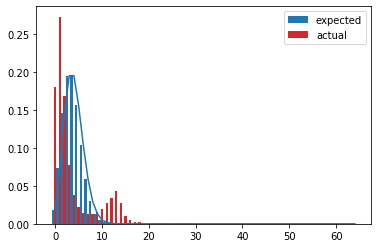

---- Sample data ----
MWU: MannwhitneyuResult(statistic=540.0, pvalue=6.363694896012101e-15)
Levene: LeveneResult(statistic=1.6599129309219912e-05, pvalue=0.9967556082976207)


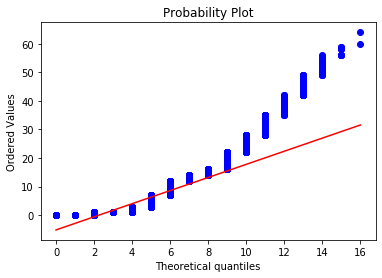

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 29.155703544288375; expected: 4; difference: 25.155703544288375
difference between std and mean :25.155721664100387
MWU: MannwhitneyuResult(statistic=687.0, pvalue=5.473004581549539e-08)
Levene: LeveneResult(statistic=8.388275950358322e-05, pvalue=0.9927087683614584)


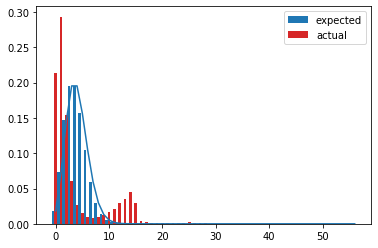

---- Sample data ----
MWU: MannwhitneyuResult(statistic=365.0, pvalue=6.860303598799348e-14)
Levene: LeveneResult(statistic=5.232996152079338e-05, pvalue=0.9942410666389971)


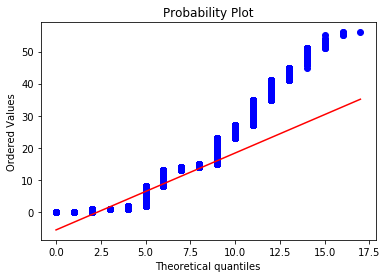

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 29.798016548065778; expected: 4; difference: 25.798016548065778
difference between std and mean :25.798026084808942
MWU: MannwhitneyuResult(statistic=818.0, pvalue=8.43538491541779e-10)
Levene: LeveneResult(statistic=2.9123150952092825e-05, pvalue=0.9957025691736073)


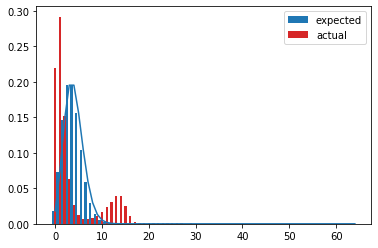

---- Sample data ----
MWU: MannwhitneyuResult(statistic=440.0, pvalue=3.227499650220037e-16)
Levene: LeveneResult(statistic=1.831254560609022e-05, pvalue=0.9965922724734261)


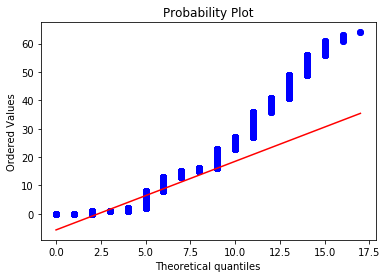

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 30.987214326833445; expected: 4; difference: 26.987214326833445
difference between std and mean :26.987219333623607
MWU: MannwhitneyuResult(statistic=945.0, pvalue=8.5987885506602e-12)
Levene: LeveneResult(statistic=1.9449796614800796e-05, pvalue=0.9964872907967199)


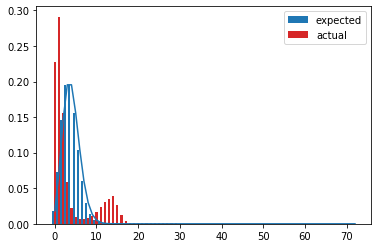

---- Sample data ----
MWU: MannwhitneyuResult(statistic=501.5, pvalue=5.435837718062367e-19)
Levene: LeveneResult(statistic=1.2344201609457596e-05, pvalue=0.997201555568661)


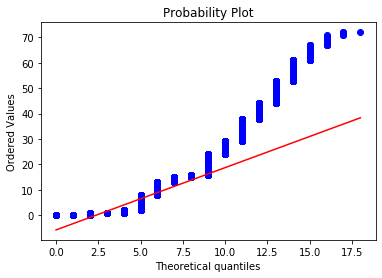

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 32.46257686614302; expected: 4; difference: 28.462576866143017
difference between std and mean :28.462579488747387
MWU: MannwhitneyuResult(statistic=1092.0, pvalue=4.199561603612497e-14)
Levene: LeveneResult(statistic=9.28106868997029e-06, pvalue=0.9975730089444522)


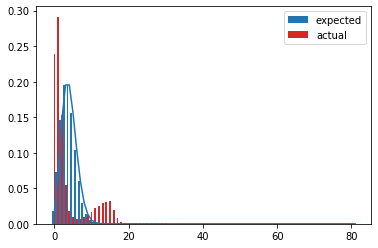

---- Sample data ----
MWU: MannwhitneyuResult(statistic=580.5, pvalue=7.04897855478709e-22)
Levene: LeveneResult(statistic=5.934553751482584e-06, pvalue=0.9980592774159094)


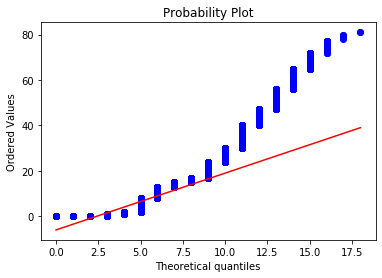

In [314]:
for N in Ns_c4:
    print(N)
    analize_result(occs_c4[N],N,plot=True,l=4)
    analize_result_2(occs_c4[N],plot=True,l=4)

### Champernowne with lambda = 1 from N=2ˆ10 up to 2ˆ26


In [315]:
Ns_c1 = [2**i for i in range(10,26)]
occs_c1 = get_amounts_for_ns(Ns2,lamb=1,use_seq='champernowne')

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 0.9637899398803711; expected: 1; difference: 0.036210060119628906
difference between std and mean :0.027420997619628906
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.0698708591528496e-05, pvalue=0.9974439609377667)


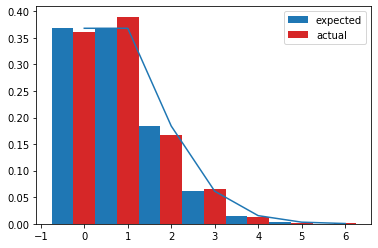

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.00011013668697097927, pvalue=0.9917991283627486)


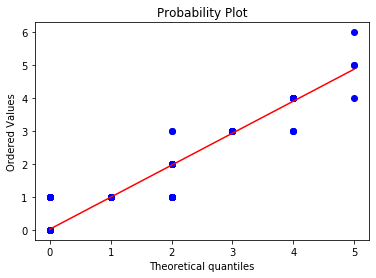

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.2148199081420898; expected: 1; difference: 0.21481990814208984
difference between std and mean :0.21970272064208984
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42499762424381904)
Levene: LeveneResult(statistic=0.0001639674369567115, pvalue=0.9899242458612219)


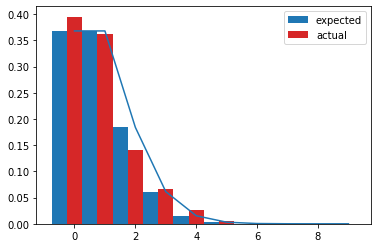

---- Sample data ----
MWU: MannwhitneyuResult(statistic=42.0, pvalue=0.28383840523588394)
Levene: LeveneResult(statistic=0.00014677010221671164, pvalue=0.9904672353771736)


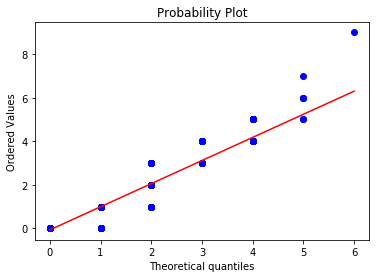

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 1.5710377097129822; expected: 1; difference: 0.5710377097129822
difference between std and mean :0.5737232565879822
MWU: MannwhitneyuResult(statistic=75.0, pvalue=0.32212122192374565)
Levene: LeveneResult(statistic=0.0001544030682276763, pvalue=0.9901885365934217)


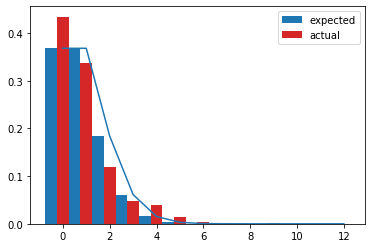

---- Sample data ----
MWU: MannwhitneyuResult(statistic=67.0, pvalue=0.18662387135503128)
Levene: LeveneResult(statistic=0.00017782529138620602, pvalue=0.9894706678968009)


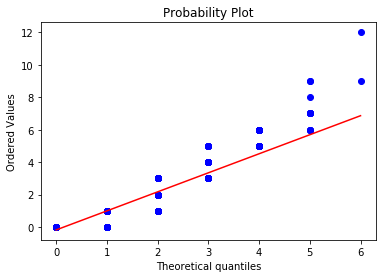

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 1.876950979232788; expected: 1; difference: 0.8769509792327881
difference between std and mean :0.8784158229827881
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)
Levene: LeveneResult(statistic=0.012594656726337753, pvalue=0.9118863424985811)


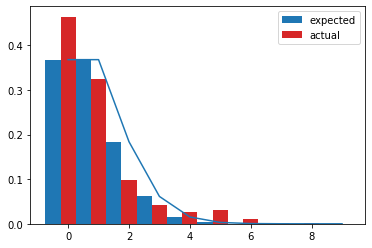

---- Sample data ----
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.23600427883305353)
Levene: LeveneResult(statistic=0.012694878813457764, pvalue=0.9115380109091266)


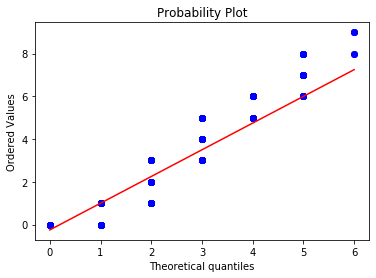

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.9963982962071896; expected: 1; difference: 0.9963982962071896
difference between std and mean :0.9971917532384396
MWU: MannwhitneyuResult(statistic=61.0, pvalue=0.11902185854256181)
Levene: LeveneResult(statistic=0.00117377645873766, pvalue=0.9729528398748535)


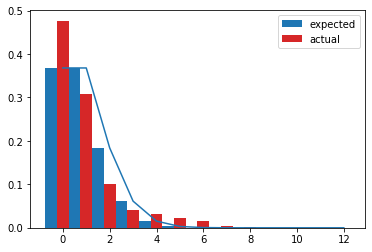

---- Sample data ----
MWU: MannwhitneyuResult(statistic=60.5, pvalue=0.11259866058489898)
Levene: LeveneResult(statistic=0.001197457833199919, pvalue=0.972681471404995)


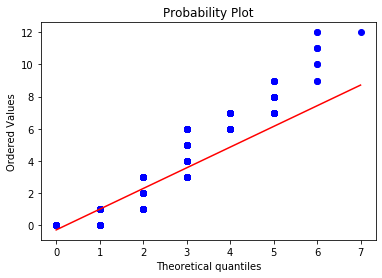

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 2.1852415166795254; expected: 1; difference: 1.1852415166795254
difference between std and mean :1.1856687627732754
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.03393072617650289)
Levene: LeveneResult(statistic=3.1247750960218544e-05, pvalue=0.9955745775231563)


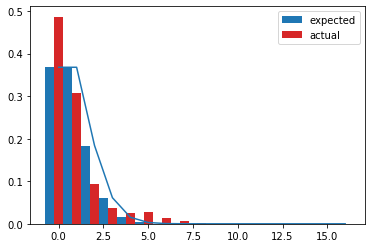

---- Sample data ----
MWU: MannwhitneyuResult(statistic=90.0, pvalue=0.03019260489622316)
Levene: LeveneResult(statistic=3.153568972696508e-05, pvalue=0.9955542350202032)


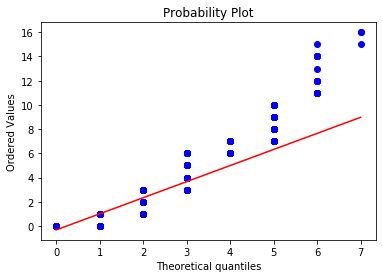

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 2.3702849817927927; expected: 1; difference: 1.3702849817927927
difference between std and mean :1.3705138636287302
MWU: MannwhitneyuResult(statistic=123.0, pvalue=0.00733342544780033)
Levene: LeveneResult(statistic=7.167880912292756e-06, pvalue=0.9978771424034737)


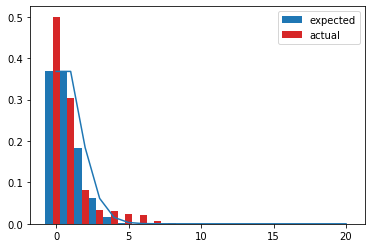

---- Sample data ----
MWU: MannwhitneyuResult(statistic=118.0, pvalue=0.004590536790179613)
Levene: LeveneResult(statistic=7.178364160576772e-06, pvalue=0.9978755906017757)


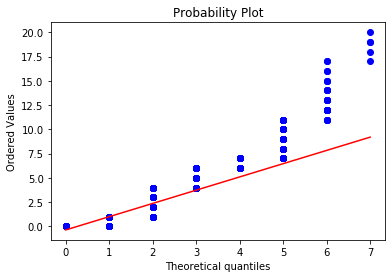

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 2.782562240958214; expected: 1; difference: 1.7825622409582138
difference between std and mean :1.7826843112707138
MWU: MannwhitneyuResult(statistic=162.0, pvalue=0.0006573522529824548)
Levene: LeveneResult(statistic=2.0574759680260487e-06, pvalue=0.9988612301309084)


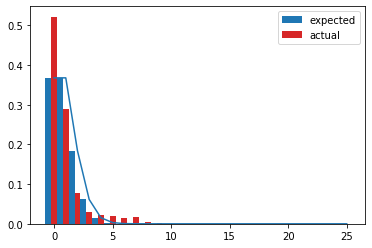

---- Sample data ----
MWU: MannwhitneyuResult(statistic=162.5, pvalue=0.0005538316090574928)
Levene: LeveneResult(statistic=2.0555572793763948e-06, pvalue=0.9988617612310883)


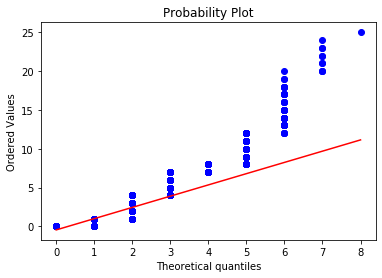

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 3.2263755756284818; expected: 1; difference: 2.2263755756284818
difference between std and mean :2.2264404254819974
MWU: MannwhitneyuResult(statistic=203.0, pvalue=4.806501554569991e-05)
Levene: LeveneResult(statistic=1.095010218297123e-06, pvalue=0.9991685433884085)


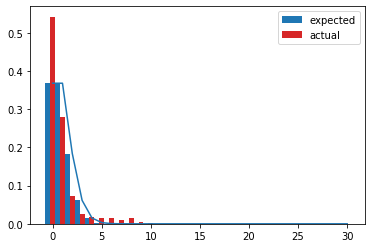

---- Sample data ----
MWU: MannwhitneyuResult(statistic=204.5, pvalue=3.795730643150767e-05)
Levene: LeveneResult(statistic=1.0935727319092753e-06, pvalue=0.9991690893206571)


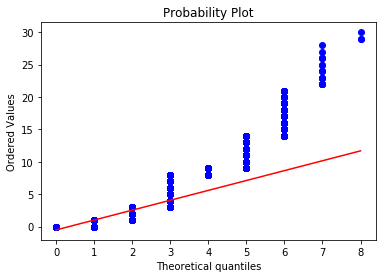

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 3.7450866687431694; expected: 1; difference: 2.7450866687431694
difference between std and mean :2.74512100101856
MWU: MannwhitneyuResult(statistic=310.0, pvalue=2.6297885140884486e-05)
Levene: LeveneResult(statistic=4.5570802034371344e-07, pvalue=0.9994632458083925)


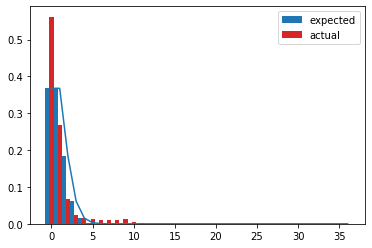

---- Sample data ----
MWU: MannwhitneyuResult(statistic=280.0, pvalue=3.3009813381174734e-06)
Levene: LeveneResult(statistic=4.561194325391503e-07, pvalue=0.9994630035665368)


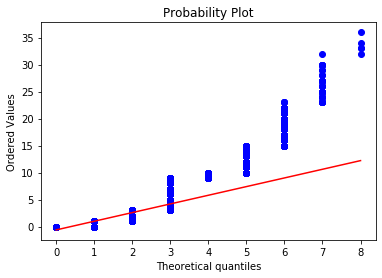

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 4.38926982846806; expected: 1; difference: 3.38926982846806
difference between std and mean :3.3892879482800717
MWU: MannwhitneyuResult(statistic=376.0, pvalue=1.1041547957272305e-06)
Levene: LeveneResult(statistic=2.6215551264870583e-07, pvalue=0.9995926881722259)


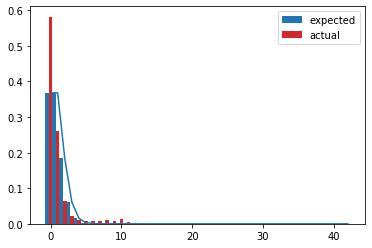

---- Sample data ----
MWU: MannwhitneyuResult(statistic=340.0, pvalue=8.780505196083263e-08)
Levene: LeveneResult(statistic=2.6225978454003663e-07, pvalue=0.9995926071687178)


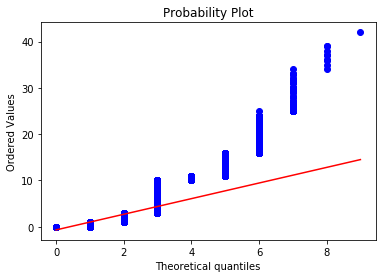

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 5.1826639174505535; expected: 1; difference: 4.1826639174505535
difference between std and mean :4.182673454193718
MWU: MannwhitneyuResult(statistic=533.0, pvalue=3.910287901172046e-07)
Levene: LeveneResult(statistic=1.0011267521635185e-07, pvalue=0.9997481878404344)


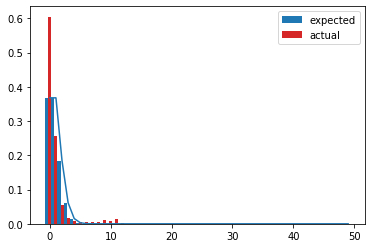

---- Sample data ----
MWU: MannwhitneyuResult(statistic=453.0, pvalue=4.7033538047599904e-09)
Levene: LeveneResult(statistic=1.0011536633777113e-07, pvalue=0.9997481844332914)


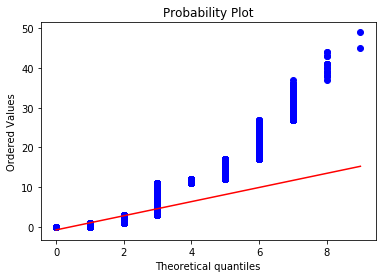

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 5.982516050313675; expected: 1; difference: 4.982516050313675
difference between std and mean :4.9825210571038365
MWU: MannwhitneyuResult(statistic=306.0, pvalue=4.700470884890722e-08)
Levene: LeveneResult(statistic=4.482743174850384e-07, pvalue=0.9994673775749704)


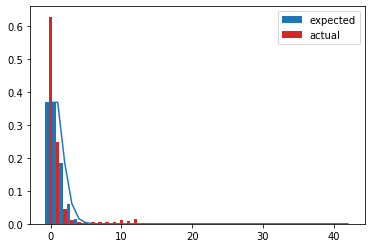

---- Sample data ----
MWU: MannwhitneyuResult(statistic=307.0, pvalue=2.0509265503535895e-08)
Levene: LeveneResult(statistic=4.4828215799892827e-07, pvalue=0.9994673729266601)


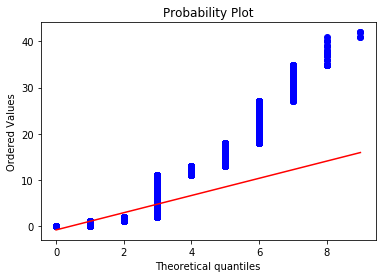

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 6.208072900765218; expected: 1; difference: 5.208072900765218
difference between std and mean :5.208075523369588
MWU: MannwhitneyuResult(statistic=372.0, pvalue=7.261149324117785e-10)
Levene: LeveneResult(statistic=9.324229774497105e-08, pvalue=0.9997569818890457)


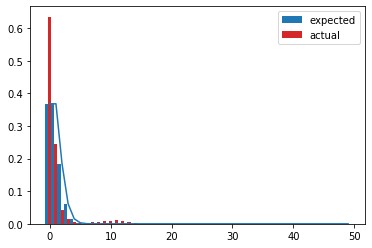

---- Sample data ----
MWU: MannwhitneyuResult(statistic=367.5, pvalue=1.8133677067310473e-10)
Levene: LeveneResult(statistic=9.322573243107595e-08, pvalue=0.999757003455587)


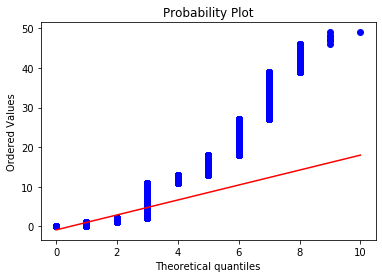

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 6.497563064096477; expected: 1; difference: 5.497563064096477
difference between std and mean :5.497564435003307
MWU: MannwhitneyuResult(statistic=436.0, pvalue=8.327000745722046e-12)
Levene: LeveneResult(statistic=5.485746811798489e-08, pvalue=0.9998135387832634)


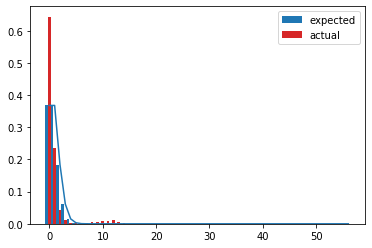

---- Sample data ----
MWU: MannwhitneyuResult(statistic=438.0, pvalue=1.9877215994225375e-12)
Levene: LeveneResult(statistic=5.485559158967322e-08, pvalue=0.9998135419531667)


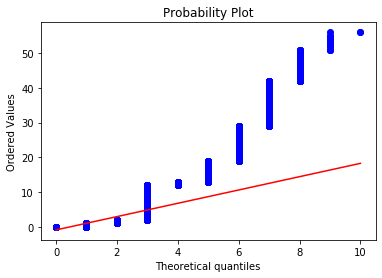

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 6.846365749835456; expected: 1; difference: 5.846365749835456
difference between std and mean :5.846366465091194
MWU: MannwhitneyuResult(statistic=515.0, pvalue=5.182194125894168e-14)
Levene: LeveneResult(statistic=3.034923181833937e-08, pvalue=0.9998612714790263)


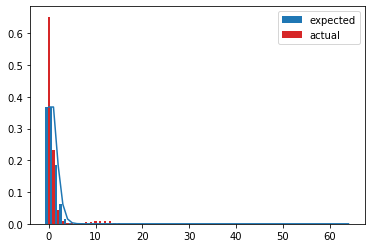

---- Sample data ----
MWU: MannwhitneyuResult(statistic=512.0, pvalue=5.279585438459663e-15)
Levene: LeveneResult(statistic=3.0349979750372056e-08, pvalue=0.9998612697901073)


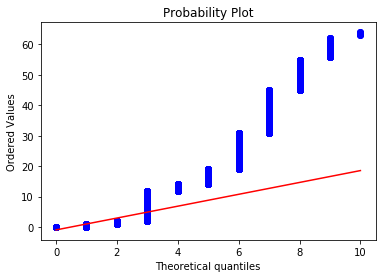

In [316]:
for N in Ns_c1:
    print(N)
    analize_result(occs_c1[N],N,plot=True,l=1)
    analize_result_2(occs_c1[N],plot=True,l=1)

### PRNG with lambda = 1 from N=2ˆ10 up to 2ˆ26

In [324]:
Ns_p1 = [2**i for i in range(10,26)]
occs_p1 = get_amounts_for_ns(Ns2,lamb=1,use_seq='prng')

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.022383689880371; expected: 1; difference: 0.022383689880371094
difference between std and mean :0.031172752380371094
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
Levene: LeveneResult(statistic=0.0026170777112080375, pvalue=0.9602075594239242)


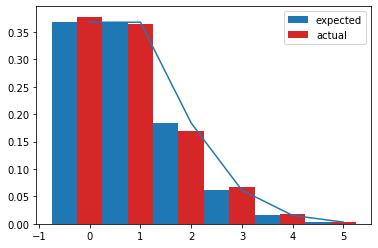

---- Sample data ----
MWU: MannwhitneyuResult(statistic=17.0, pvalue=0.30805209802298494)
Levene: LeveneResult(statistic=0.01811298492453336, pvalue=0.8953713681742128)


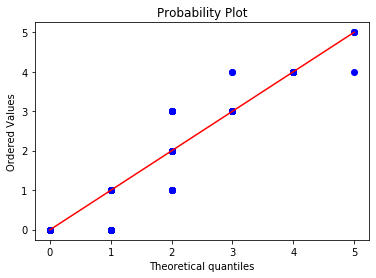

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 0.9521245956420898; expected: 1; difference: 0.047875404357910156
difference between std and mean :0.042992591857910156
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.00021377047256378718, pvalue=0.9885749070338817)


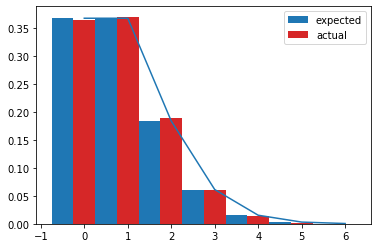

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.449051905879462)
Levene: LeveneResult(statistic=4.341213600732551e-06, pvalue=0.9983717995016883)


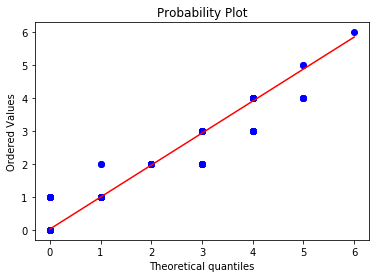

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 0.9811939597129822; expected: 1; difference: 0.018806040287017822
difference between std and mean :0.016120493412017822
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=8.64119729123354e-05, pvalue=0.9927358829957941)


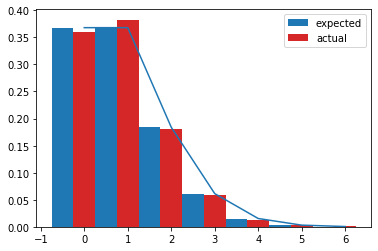

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.5, pvalue=0.47450184322152916)
Levene: LeveneResult(statistic=0.000636735979808318, pvalue=0.9802833822979098)


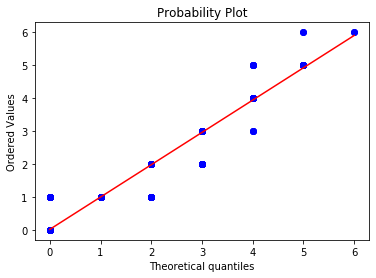

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 0.9843728542327881; expected: 1; difference: 0.015627145767211914
difference between std and mean :0.014162302017211914
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.3167888964496023e-07, pvalue=0.9996219042280201)


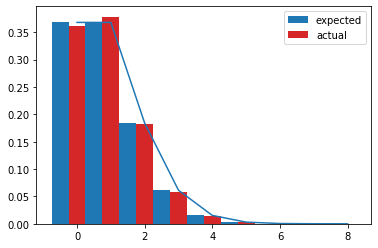

---- Sample data ----
MWU: MannwhitneyuResult(statistic=37.0, pvalue=0.3952764999744447)
Levene: LeveneResult(statistic=8.594989155701791e-06, pvalue=0.9976970706586771)


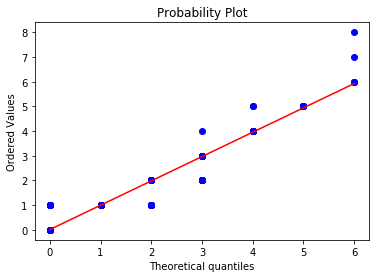

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.0028680227696896; expected: 1; difference: 0.00286802276968956
difference between std and mean :0.00366147980093956
MWU: MannwhitneyuResult(statistic=22.0, pvalue=0.3990403147291498)
Levene: LeveneResult(statistic=1.5356545482604595e-06, pvalue=0.999031612241479)


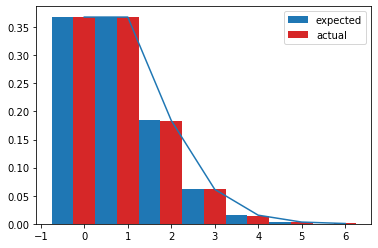

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491633936346191)
Levene: LeveneResult(statistic=2.6985096502247498e-05, pvalue=0.9959405937315557)


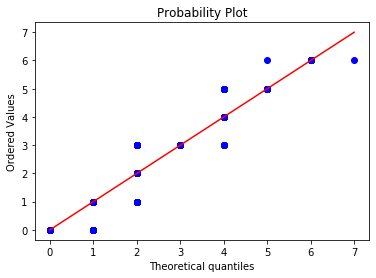

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 0.9979246221482754; expected: 1; difference: 0.0020753778517246246
difference between std and mean :0.0016481317579746246
MWU: MannwhitneyuResult(statistic=22.0, pvalue=0.3990403147291498)
Levene: LeveneResult(statistic=6.046152490761679e-09, pvalue=0.9999392365867553)


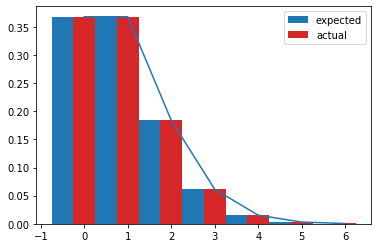

---- Sample data ----
MWU: MannwhitneyuResult(statistic=25.0, pvalue=0.38616872064639024)
Levene: LeveneResult(statistic=0.015781542450962385, pvalue=0.9019510807365768)


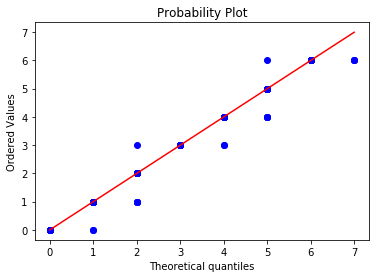

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 0.9970244837459177; expected: 1; difference: 0.002975516254082322
difference between std and mean :0.002746634418144822
MWU: MannwhitneyuResult(statistic=31.0, pvalue=0.4790455641133508)
Levene: LeveneResult(statistic=2.1699862682593853e-06, pvalue=0.998845431558954)


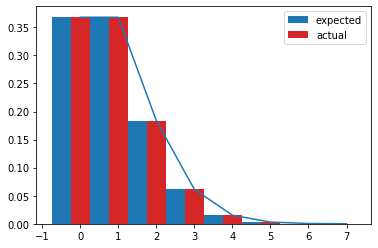

---- Sample data ----
MWU: MannwhitneyuResult(statistic=30.5, pvalue=0.45814889899892497)
Levene: LeveneResult(statistic=1.0054568532485083e-05, pvalue=0.9975147373257887)


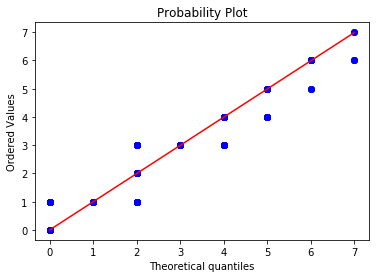

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 0.9997100681066513; expected: 1; difference: 0.00028993189334869385
difference between std and mean :0.00016786158084869385
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=7.205281415455876e-07, pvalue=0.9993332177560078)


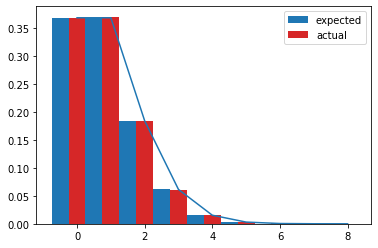

---- Sample data ----
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.429909602527079)
Levene: LeveneResult(statistic=1.4840302146081324e-06, pvalue=0.9990430706717879)


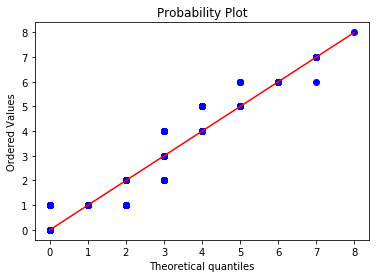

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 0.9958152728941059; expected: 1; difference: 0.004184727105894126
difference between std and mean :0.004119877252378501
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42502551244863873)
Levene: LeveneResult(statistic=2.817461267648492e-08, pvalue=0.9998679190314844)


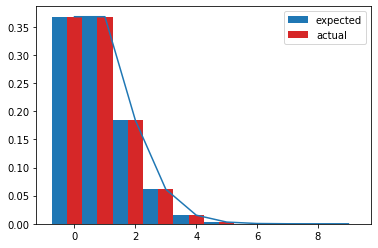

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.48491364651063584)
Levene: LeveneResult(statistic=2.175656678335918e-09, pvalue=0.9999632965773781)


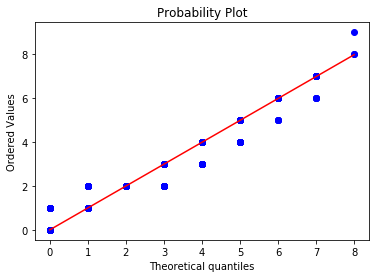

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 1.0002288806572324; expected: 1; difference: 0.0002288806572323665
difference between std and mean :0.0002632129326229915
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=8.845318563554477e-08, pvalue=0.9997663771389917)


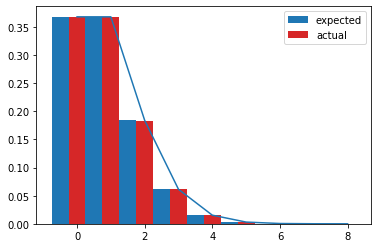

---- Sample data ----
MWU: MannwhitneyuResult(statistic=39.5, pvalue=0.4823829020325924)
Levene: LeveneResult(statistic=1.5755720604420935e-09, pvalue=0.9999688198866565)


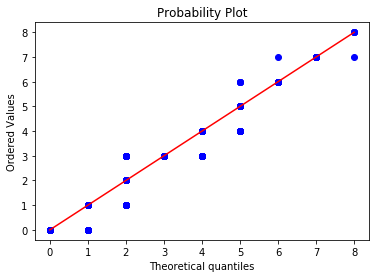

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 1.0010480877454029; expected: 1; difference: 0.0010480877454028814
difference between std and mean :0.0010662075574146002
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=3.959420669815077e-09, pvalue=0.9999504861023633)


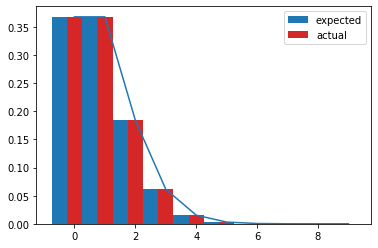

---- Sample data ----
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849249884965778)
Levene: LeveneResult(statistic=1.7229249141334907e-08, pvalue=0.9998967132836541)


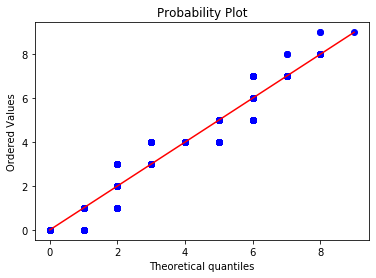

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 1.0031042098089524; expected: 1; difference: 0.0031042098089524295
difference between std and mean :0.003113746552116492
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=1.1348662497788992e-08, pvalue=0.9999160567057859)


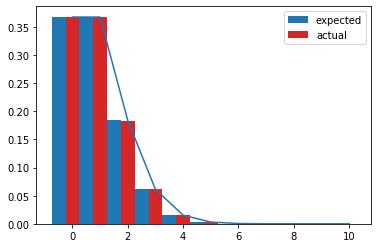

---- Sample data ----
MWU: MannwhitneyuResult(statistic=59.5, pvalue=0.48689297622562533)
Levene: LeveneResult(statistic=9.54173747115495e-11, pvalue=0.9999923028210215)


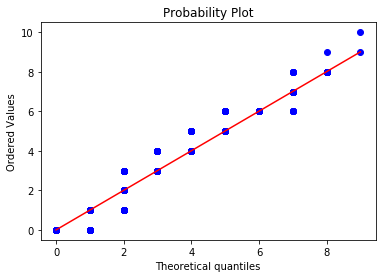

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 1.0020730495202201; expected: 1; difference: 0.0020730495202201382
difference between std and mean :0.002078056310381271
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=6.06645987803252e-08, pvalue=0.9998061887654127)


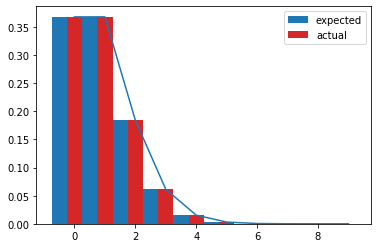

---- Sample data ----
MWU: MannwhitneyuResult(statistic=49.5, pvalue=0.3623427265788608)
Levene: LeveneResult(statistic=0.018754030037484975, pvalue=0.8925147212846375)


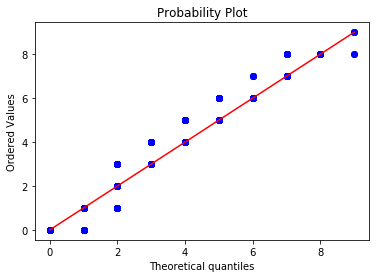

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 0.9999969005515937; expected: 1; difference: 3.0994484062629724e-06
difference between std and mean :4.768440361457849e-07
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=6.825001722074463e-09, pvalue=0.9999349023994546)


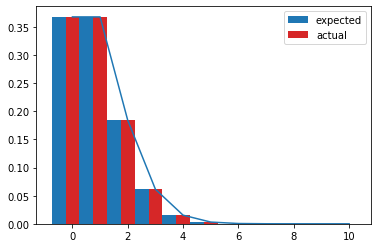

---- Sample data ----
MWU: MannwhitneyuResult(statistic=58.5, pvalue=0.46075757715113363)
Levene: LeveneResult(statistic=3.0962368310171474e-09, pvalue=0.9999561539267031)


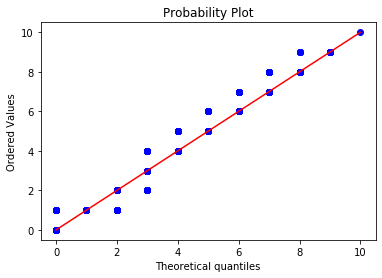

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 1.0002638697605413; expected: 1; difference: 0.00026386976054126876
difference between std and mean :0.00026524066737110275
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=1.415051907729911e-09, pvalue=0.9999703585178918)


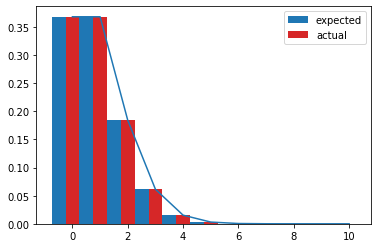

---- Sample data ----
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47382226481129724)
Levene: LeveneResult(statistic=2.8206139460102948e-09, pvalue=0.9999581509735976)


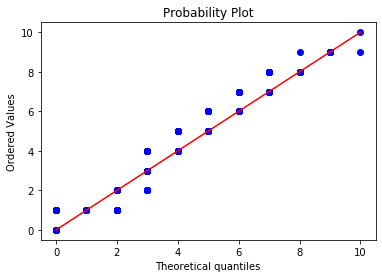

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 0.9999827742571481; expected: 1; difference: 1.7225742851900705e-05
difference between std and mean :1.6510487114596017e-05
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=6.657249554756807e-10, pvalue=0.9999796688871376)


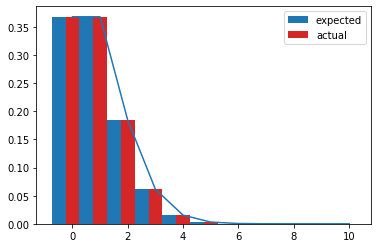

---- Sample data ----
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=5.494633956428045e-11, pvalue=0.9999941590128245)


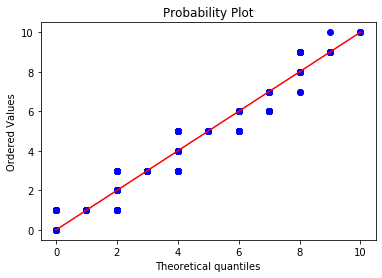

In [325]:
for N in Ns_p1:
    print(N)
    analize_result(occs_p1[N],N,plot=True,l=1)
    analize_result_2(occs_p1[N],plot=True,l=1)

### PRNG with lambda = 4 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 3.9640960693359375; expected: 4; difference: 0.0359039306640625
difference between std and mean :0.0085601806640625
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47379269458935785)
Levene: LeveneResult(statistic=2.0586821689308867e-06, pvalue=0.9988694022136186)


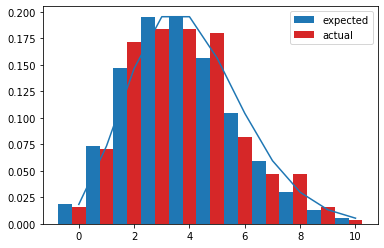

---- Sample data ----
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.07295883112207359)
Levene: LeveneResult(statistic=0.3989652062467366, pvalue=0.5347778183741716)


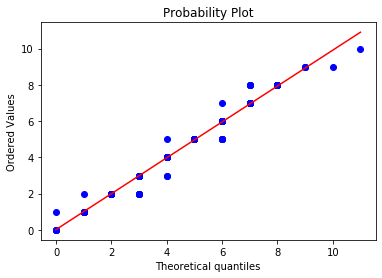

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 3.421630859375; expected: 4; difference: 0.578369140625
difference between std and mean :0.562744140625
MWU: MannwhitneyuResult(statistic=58.0, pvalue=0.4477424507327276)
Levene: LeveneResult(statistic=0.019681888414735643, pvalue=0.8898324569821794)


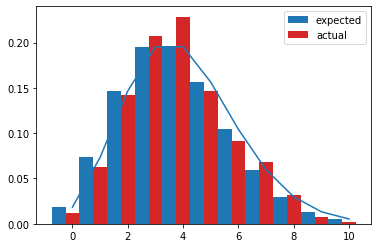

---- Sample data ----
MWU: MannwhitneyuResult(statistic=39.5, pvalue=0.08691074364749757)
Levene: LeveneResult(statistic=0.34402132700028826, pvalue=0.5640794387268236)


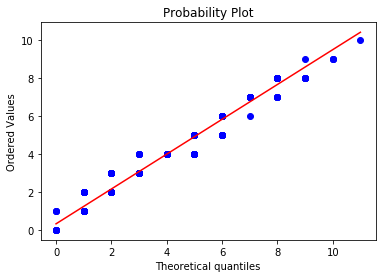

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 3.795821189880371; expected: 4; difference: 0.2041788101196289
difference between std and mean :0.1953897476196289
MWU: MannwhitneyuResult(statistic=98.0, pvalue=0.4908330613926762)
Levene: LeveneResult(statistic=0.010546515400581316, pvalue=0.9189920563200986)


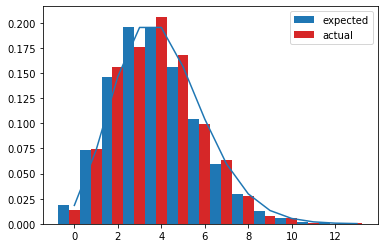

---- Sample data ----
MWU: MannwhitneyuResult(statistic=61.0, pvalue=0.044044319631627124)
Levene: LeveneResult(statistic=0.045883512304596676, pvalue=0.8320587586926391)


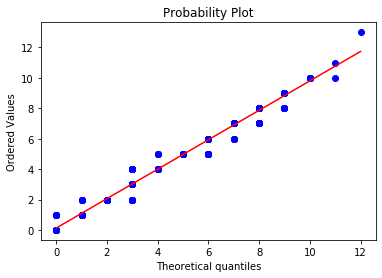

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 3.78024959564209; expected: 4; difference: 0.21975040435791016
difference between std and mean :0.21486759185791016
MWU: MannwhitneyuResult(statistic=81.0, pvalue=0.43884477389518206)
Levene: LeveneResult(statistic=0.0001829173185443645, pvalue=0.9893209876541839)


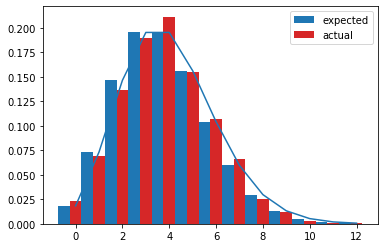

---- Sample data ----
MWU: MannwhitneyuResult(statistic=52.0, pvalue=0.049346989061694865)
Levene: LeveneResult(statistic=0.13859741326360075, pvalue=0.7129466017758725)


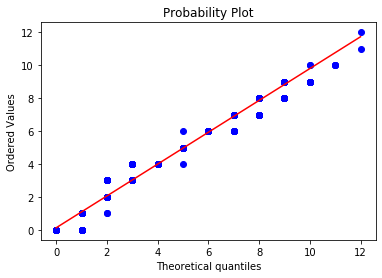

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 4.180412709712982; expected: 4; difference: 0.18041270971298218
difference between std and mean :0.18309825658798218
MWU: MannwhitneyuResult(statistic=98.0, pvalue=0.4908330613926762)
Levene: LeveneResult(statistic=0.0005360088199901441, pvalue=0.9817059079205402)


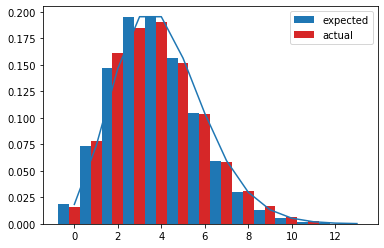

---- Sample data ----
MWU: MannwhitneyuResult(statistic=58.0, pvalue=0.033623447957292885)
Levene: LeveneResult(statistic=0.07375481388024115, pvalue=0.7880910166705082)


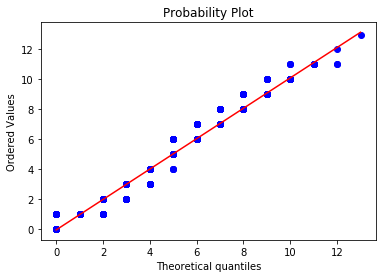

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 4.023923635482788; expected: 4; difference: 0.023923635482788086
difference between std and mean :0.025388479232788086
MWU: MannwhitneyuResult(statistic=97.0, pvalue=0.4908343159714798)
Levene: LeveneResult(statistic=2.8340822759460706e-05, pvalue=0.9957930313324879)


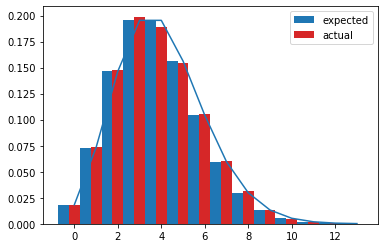

---- Sample data ----
MWU: MannwhitneyuResult(statistic=56.0, pvalue=0.027327389303882357)
Levene: LeveneResult(statistic=0.06895180264828649, pvalue=0.7949386159180313)


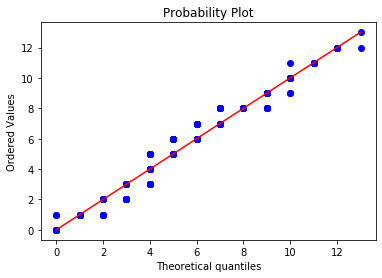

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 3.9374383352696896; expected: 4; difference: 0.06256166473031044
difference between std and mean :0.06176820769906044
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.4834555492223808)
Levene: LeveneResult(statistic=0.00022598482963857148, pvalue=0.9881126251697799)


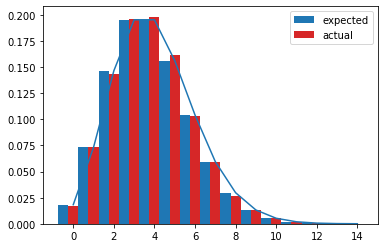

---- Sample data ----
MWU: MannwhitneyuResult(statistic=65.0, pvalue=0.024897116994230337)
Levene: LeveneResult(statistic=0.03537413736884763, pvalue=0.8521702845833533)


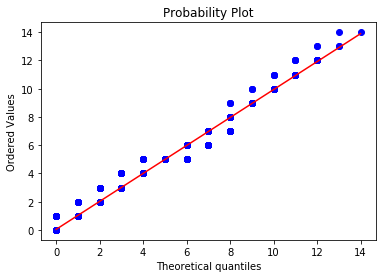

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 3.9620969854295254; expected: 4; difference: 0.037903014570474625
difference between std and mean :0.037475768476724625
MWU: MannwhitneyuResult(statistic=128.0, pvalue=0.4924819045390597)
Levene: LeveneResult(statistic=1.4804038475025975e-05, pvalue=0.9969555376653605)


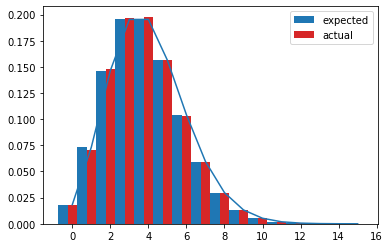

---- Sample data ----
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.01751439769803)
Levene: LeveneResult(statistic=0.019090971650791932, pvalue=0.8910292694546889)


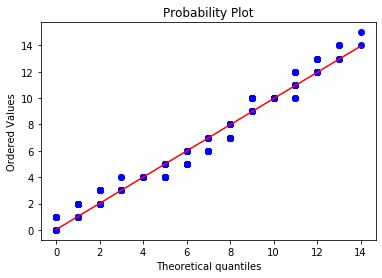

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 3.9815215540584177; expected: 4; difference: 0.018478445941582322
difference between std and mean :0.018249564105644822
MWU: MannwhitneyuResult(statistic=98.0, pvalue=0.4908343159714798)
Levene: LeveneResult(statistic=2.356999613779492e-05, pvalue=0.9961634296621039)


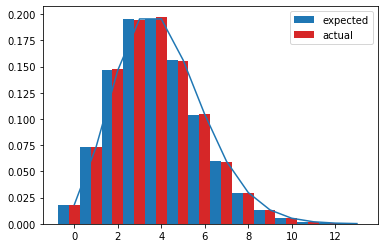

---- Sample data ----
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.03075178029688904)
Levene: LeveneResult(statistic=0.06621445932599689, pvalue=0.7989560474928434)


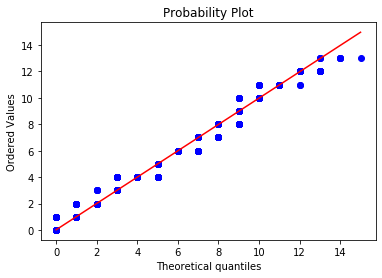

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 3.9804839938879013; expected: 4; difference: 0.019516006112098694
difference between std and mean :0.019393935799598694
MWU: MannwhitneyuResult(statistic=128.0, pvalue=0.4924819045390597)
Levene: LeveneResult(statistic=4.159393363817982e-06, pvalue=0.9983862498475858)


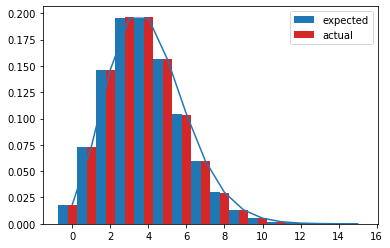

---- Sample data ----
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.017752430528769868)
Levene: LeveneResult(statistic=0.019497779411555248, pvalue=0.889882057645897)


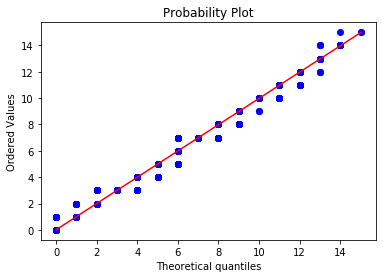

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 3.992198939886294; expected: 4; difference: 0.007801060113706182
difference between std and mean :0.007736210260190557
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.1065958371336695e-07, pvalue=0.9997366446182434)


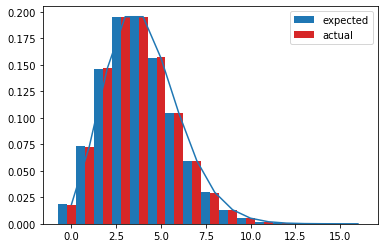

---- Sample data ----
MWU: MannwhitneyuResult(statistic=80.0, pvalue=0.013254609571501208)
Levene: LeveneResult(statistic=0.011324515023256248, pvalue=0.9159160839865518)


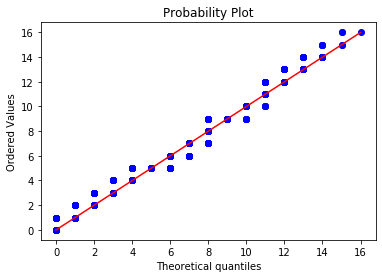

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 4.0061264026298895; expected: 4; difference: 0.006126402629889505
difference between std and mean :0.00616073490528013
MWU: MannwhitneyuResult(statistic=161.0, pvalue=0.4936884633429517)
Levene: LeveneResult(statistic=4.6496177649298216e-07, pvalue=0.9994599228877445)


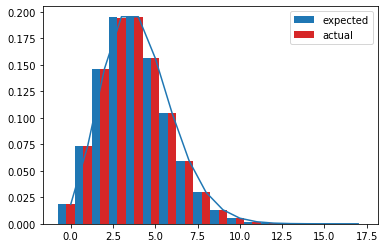

---- Sample data ----
MWU: MannwhitneyuResult(statistic=92.0, pvalue=0.01350264584460041)
Levene: LeveneResult(statistic=0.005491991126516215, pvalue=0.9413587726223671)


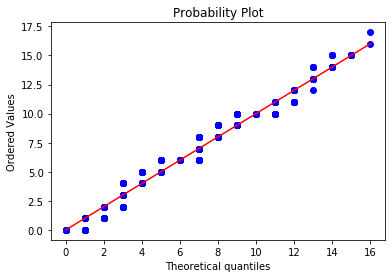

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 4.0000333782727475; expected: 4; difference: 3.337827274751959e-05
difference between std and mean :5.149808475923834e-05
MWU: MannwhitneyuResult(statistic=179.0, pvalue=0.4883539983045295)
Levene: LeveneResult(statistic=1.8376941353037484e-07, pvalue=0.9996603269274287)


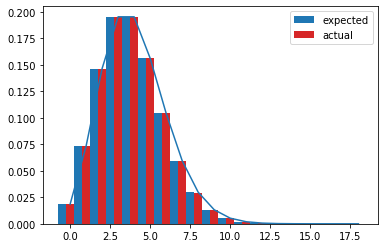

---- Sample data ----
MWU: MannwhitneyuResult(statistic=106.0, pvalue=0.01461748755393779)
Levene: LeveneResult(statistic=0.00255175028715002, pvalue=0.9599913584156883)


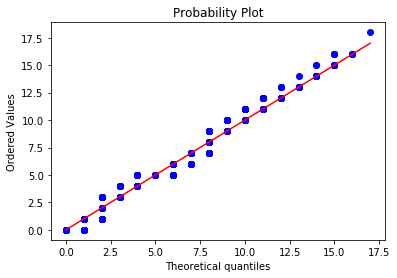

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 3.999888420014031; expected: 4; difference: 0.00011157998596900143
difference between std and mean :0.00010204324280493893
MWU: MannwhitneyuResult(statistic=160.0, pvalue=0.4810729247197727)
Levene: LeveneResult(statistic=1.233117892312595e-07, pvalue=0.9997218689501043)


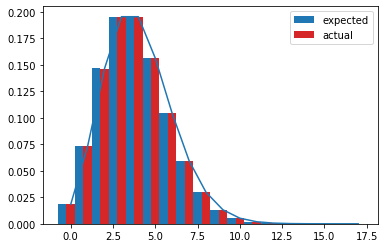

---- Sample data ----
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.012458831573657786)
Levene: LeveneResult(statistic=0.005381410360139988, pvalue=0.9419510423170994)


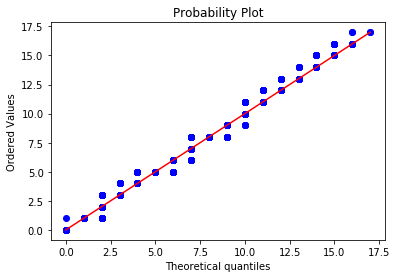

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 4.002249479268754; expected: 4; difference: 0.0022494792687544063
difference between std and mean :0.002254486058915539
MWU: MannwhitneyuResult(statistic=180.0, pvalue=0.5)
Levene: LeveneResult(statistic=4.0866500124211705e-09, pvalue=0.9999493466362438)


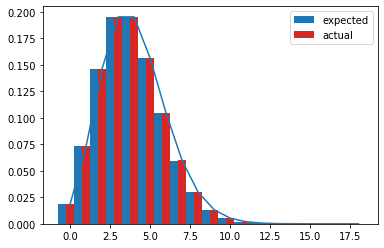

---- Sample data ----
MWU: MannwhitneyuResult(statistic=102.5, pvalue=0.011507401360997255)
Levene: LeveneResult(statistic=0.002519229095940068, pvalue=0.960246902850807)


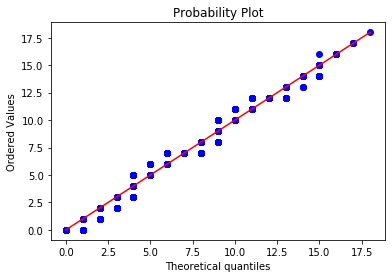

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 3.9998207092216385; expected: 4; difference: 0.0001792907783615405
difference between std and mean :0.00017666817399142332
MWU: MannwhitneyuResult(statistic=177.0, pvalue=0.46510165926432856)
Levene: LeveneResult(statistic=4.829228329466412e-08, pvalue=0.9998258740918354)


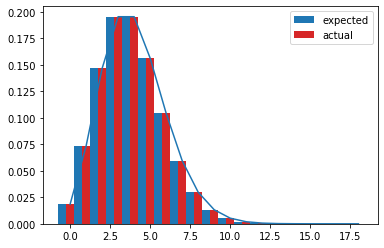

---- Sample data ----
MWU: MannwhitneyuResult(statistic=102.5, pvalue=0.011507401360997255)
Levene: LeveneResult(statistic=0.0025094192329356405, pvalue=0.9603243108619228)


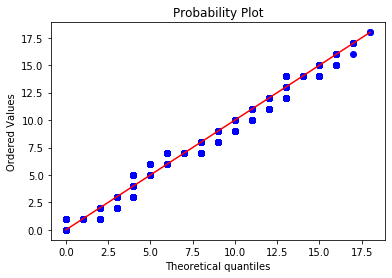

In [328]:
perform_test(seq='prng',lamb=4)

### PRNG with lambda = 32 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 31.734375; expected: 32; difference: 0.265625
difference between std and mean :0.140625
MWU: MannwhitneyuResult(statistic=510.0, pvalue=0.00013259633904846936)
Levene: LeveneResult(statistic=0.06422326079433467, pvalue=0.8005605110646501)


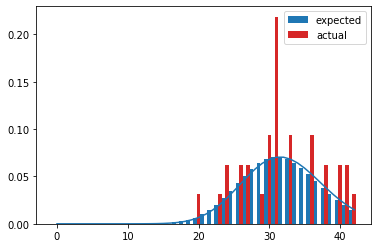

---- Sample data ----
MWU: MannwhitneyuResult(statistic=723.0, pvalue=0.0072879939410245564)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


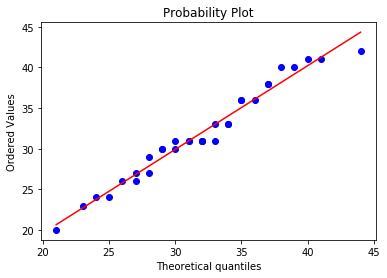

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 32.572021484375; expected: 32; difference: 0.572021484375
difference between std and mean :0.650146484375
MWU: MannwhitneyuResult(statistic=712.0, pvalue=0.03250119677338793)
Levene: LeveneResult(statistic=0.1107800755216335, pvalue=0.740087030763098)


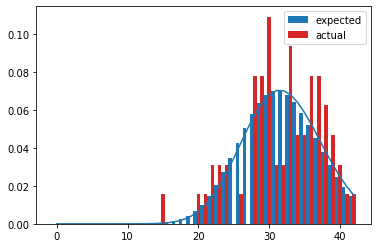

---- Sample data ----
MWU: MannwhitneyuResult(statistic=575.0, pvalue=0.00010308524800040646)
Levene: LeveneResult(statistic=0.0007855165706590882, pvalue=0.9777070422384843)


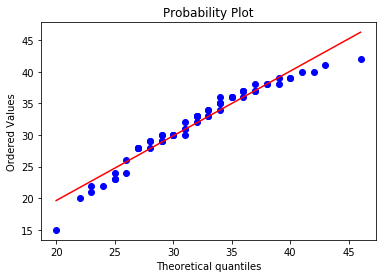

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 28.497802734375; expected: 32; difference: 3.502197265625
difference between std and mean :3.455322265625
MWU: MannwhitneyuResult(statistic=834.0, pvalue=0.03954148346328714)
Levene: LeveneResult(statistic=0.03642206173224807, pvalue=0.8490763761122346)


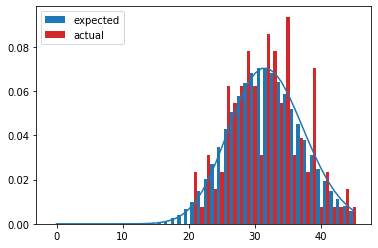

---- Sample data ----
MWU: MannwhitneyuResult(statistic=647.5, pvalue=7.092599516026412e-05)
Levene: LeveneResult(statistic=0.003131959910913135, pvalue=0.9554946067259003)


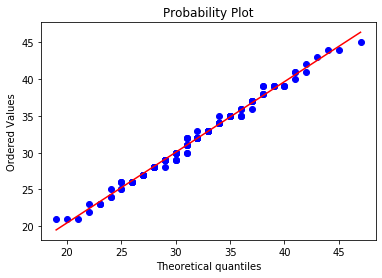

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 38.01878356933594; expected: 32; difference: 6.0187835693359375
difference between std and mean :6.0461273193359375
MWU: MannwhitneyuResult(statistic=1256.0, pvalue=0.06205054769117199)
Levene: LeveneResult(statistic=0.0019619751397162025, pvalue=0.9647516975040007)


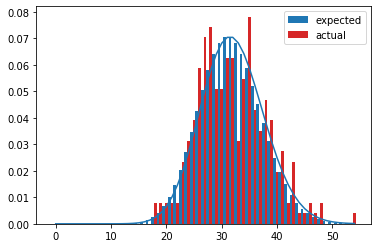

---- Sample data ----
MWU: MannwhitneyuResult(statistic=837.5, pvalue=9.921192848148267e-07)
Levene: LeveneResult(statistic=0.004764223854998189, pvalue=0.9450986629403484)


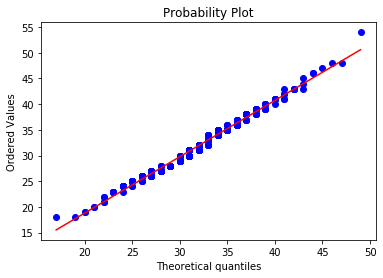

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 31.499755859375; expected: 32; difference: 0.500244140625
difference between std and mean :0.484619140625
MWU: MannwhitneyuResult(statistic=1097.0, pvalue=0.08631341891079125)
Levene: LeveneResult(statistic=0.0038191833033273423, pvalue=0.9508458190674051)


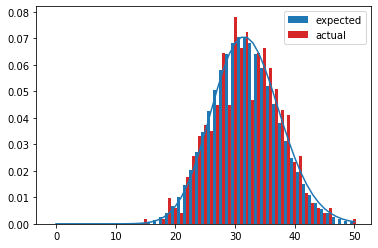

---- Sample data ----
MWU: MannwhitneyuResult(statistic=704.5, pvalue=1.8327518907334753e-06)
Levene: LeveneResult(statistic=0.0034610032358584016, pvalue=0.9532046837448624)


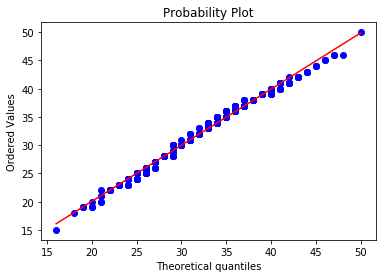

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 33.55753993988037; expected: 32; difference: 1.557539939880371
difference between std and mean :1.566329002380371
MWU: MannwhitneyuResult(statistic=1091.0, pvalue=0.13656254869563506)
Levene: LeveneResult(statistic=4.759318088099746e-05, pvalue=0.9945096368320536)


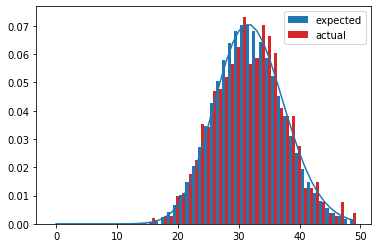

---- Sample data ----
MWU: MannwhitneyuResult(statistic=640.5, pvalue=7.523808280673665e-07)
Levene: LeveneResult(statistic=0.00889083913283396, pvalue=0.9250703226540151)


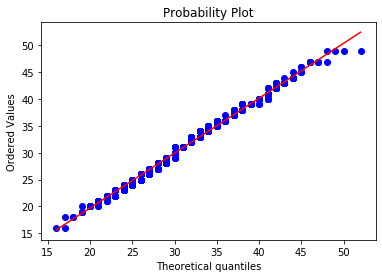

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 32.03708553314209; expected: 32; difference: 0.037085533142089844
difference between std and mean :0.041968345642089844
MWU: MannwhitneyuResult(statistic=1232.0, pvalue=0.13796613349713183)
Levene: LeveneResult(statistic=0.0007688635877899414, pvalue=0.9779319193176369)


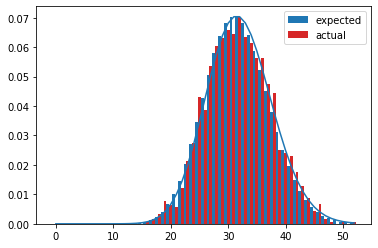

---- Sample data ----
MWU: MannwhitneyuResult(statistic=704.0, pvalue=2.7425614996723214e-07)
Levene: LeveneResult(statistic=0.003168207777501468, pvalue=0.9552213029768419)


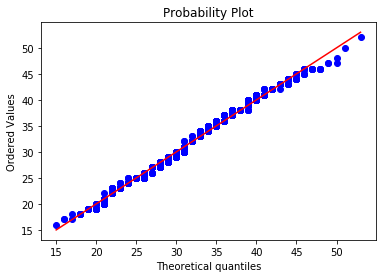

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 33.12230724096298; expected: 32; difference: 1.1223072409629822
difference between std and mean :1.1249927878379822
MWU: MannwhitneyuResult(statistic=1325.0, pvalue=0.20740046359767145)
Levene: LeveneResult(statistic=5.348022812971822e-05, pvalue=0.9941788536872002)


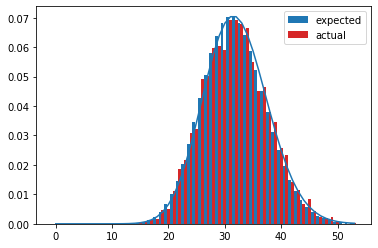

---- Sample data ----
MWU: MannwhitneyuResult(statistic=663.5, pvalue=2.5267848907211236e-08)
Levene: LeveneResult(statistic=0.0031076976991972496, pvalue=0.955648515061951)


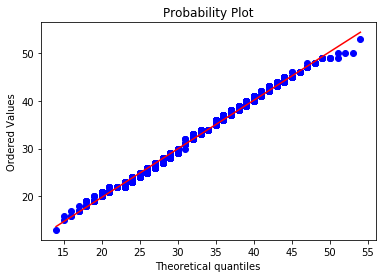

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 31.929441213607788; expected: 32; difference: 0.07055878639221191
difference between std and mean :0.06909394264221191
MWU: MannwhitneyuResult(statistic=1565.0, pvalue=0.2597875646154668)
Levene: LeveneResult(statistic=0.00011931325355129198, pvalue=0.991303924414002)


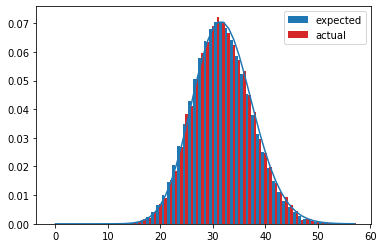

---- Sample data ----
MWU: MannwhitneyuResult(statistic=700.5, pvalue=1.0025731602704064e-09)
Levene: LeveneResult(statistic=0.0009522861419272041, pvalue=0.9754358422972502)


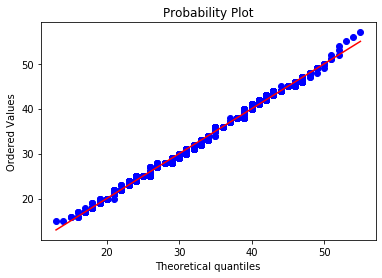

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 31.92352231964469; expected: 32; difference: 0.07647768035531044
difference between std and mean :0.07568422332406044
MWU: MannwhitneyuResult(statistic=1564.0, pvalue=0.36684146010635854)
Levene: LeveneResult(statistic=1.3573351170987946e-05, pvalue=0.9970669921965145)


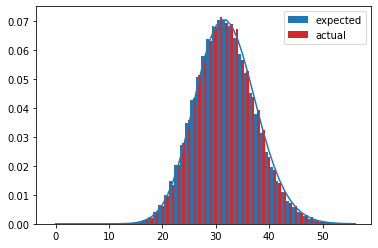

---- Sample data ----
MWU: MannwhitneyuResult(statistic=616.5, pvalue=2.73959714949884e-10)
Levene: LeveneResult(statistic=0.0017456398584573653, pvalue=0.9667477891513546)


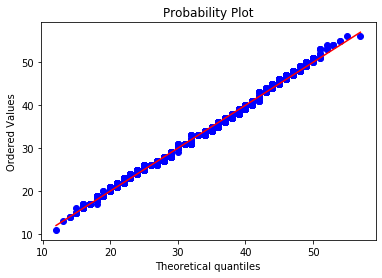

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 31.720458801835775; expected: 32; difference: 0.2795411981642246
difference between std and mean :0.2791139520704746
MWU: MannwhitneyuResult(statistic=1578.0, pvalue=0.28366246914045934)
Levene: LeveneResult(statistic=2.7135419705020023e-05, pvalue=0.9958528097027608)


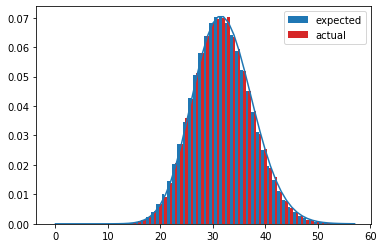

---- Sample data ----
MWU: MannwhitneyuResult(statistic=674.0, pvalue=4.4450975236274347e-10)
Levene: LeveneResult(statistic=0.001101896021129418, pvalue=0.9735772795728036)


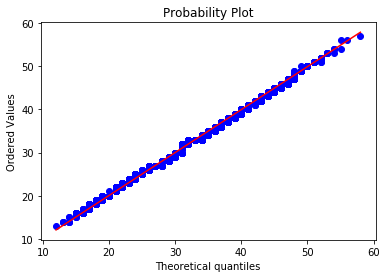

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 31.922561593120918; expected: 32; difference: 0.07743840687908232
difference between std and mean :0.07720952504314482
MWU: MannwhitneyuResult(statistic=1845.0, pvalue=0.35103624784252163)
Levene: LeveneResult(statistic=1.6192841180604394e-07, pvalue=0.9996795858846095)


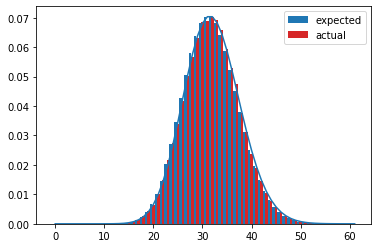

---- Sample data ----
MWU: MannwhitneyuResult(statistic=728.0, pvalue=4.824702750839323e-11)
Levene: LeveneResult(statistic=0.000412206095811644, pvalue=0.9838349426939609)


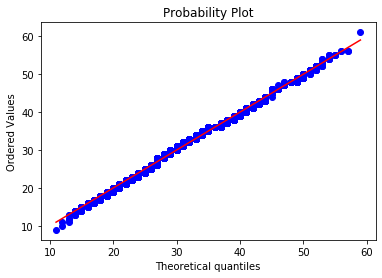

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 31.971527084708214; expected: 32; difference: 0.028472915291786194
difference between std and mean :0.028350844979286194
MWU: MannwhitneyuResult(statistic=1689.0, pvalue=0.3918183889401977)
Levene: LeveneResult(statistic=1.1148650401219125e-07, pvalue=0.9997341631197263)


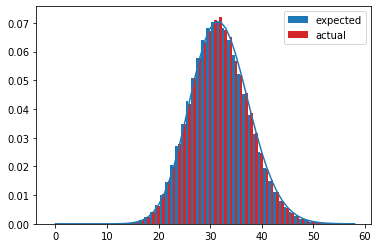

---- Sample data ----
MWU: MannwhitneyuResult(statistic=605.5, pvalue=2.837617809106698e-11)
Levene: LeveneResult(statistic=0.000977234052816367, pvalue=0.9751153205871468)


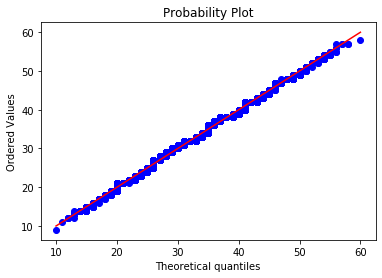

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 32.0262107807066; expected: 32; difference: 0.02621078070659877
difference between std and mean :0.026275630560114394
MWU: MannwhitneyuResult(statistic=1880.0, pvalue=0.41783376046457543)
Levene: LeveneResult(statistic=4.726776995751363e-06, pvalue=0.9982688594271789)


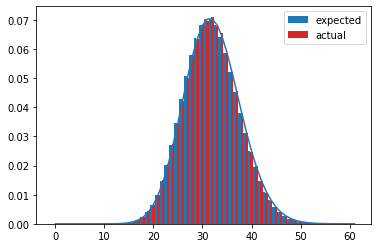

---- Sample data ----
MWU: MannwhitneyuResult(statistic=620.5, pvalue=1.8171132023197238e-12)
Levene: LeveneResult(statistic=0.0004603195586864954, pvalue=0.9829177038519599)


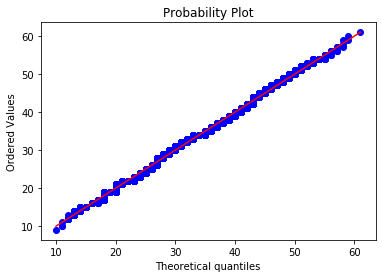

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 31.897613524211916; expected: 32; difference: 0.10238647578808369
difference between std and mean :0.10235214351269306
MWU: MannwhitneyuResult(statistic=1979.0, pvalue=0.37199345330823713)
Levene: LeveneResult(statistic=2.1430982787578846e-06, pvalue=0.9988342665389521)


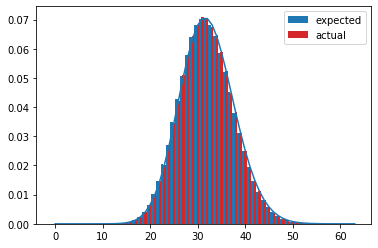

---- Sample data ----
MWU: MannwhitneyuResult(statistic=727.0, pvalue=5.255419535400224e-12)
Levene: LeveneResult(statistic=0.0002662290955388962, pvalue=0.9870076799417347)


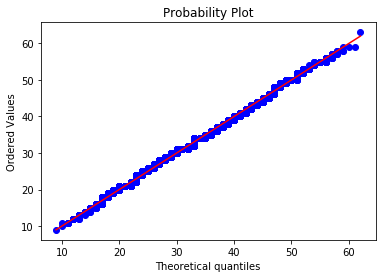

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 31.924351691871383; expected: 32; difference: 0.075648308128617
difference between std and mean :0.07563018831660528
MWU: MannwhitneyuResult(statistic=2052.0, pvalue=0.3899444092413268)
Levene: LeveneResult(statistic=1.9216123388713423e-07, pvalue=0.9996509202124395)


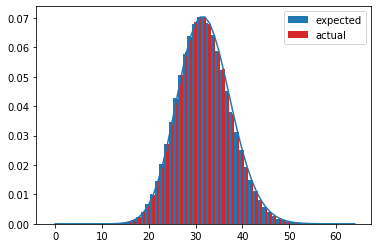

---- Sample data ----
MWU: MannwhitneyuResult(statistic=716.0, pvalue=1.3104689741267034e-12)
Levene: LeveneResult(statistic=0.0001906750341761691, pvalue=0.98900425028158)


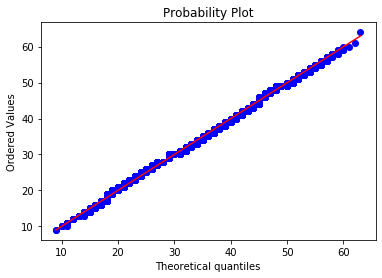

In [329]:
perform_test(seq='prng',lamb=32)

### Rule 30 with lambda = 1 from N=2ˆ10 up to 2ˆ26


1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.004805564880371; expected: 1; difference: 0.004805564880371094
difference between std and mean :0.013594627380371094
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.7998015293992698e-05, pvalue=0.9958651089193592)


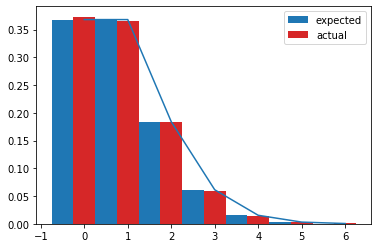

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.8824118117344417e-05, pvalue=0.9951308808542243)


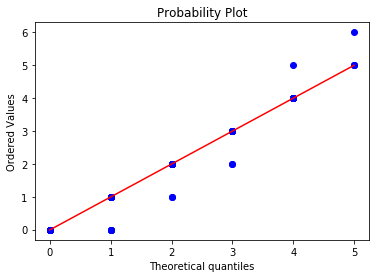

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 0.9687261581420898; expected: 1; difference: 0.031273841857910156
difference between std and mean :0.026391029357910156
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.00027471879094409225, pvalue=0.9870483443786512)


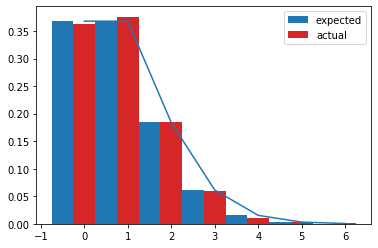

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.002127612809635795, pvalue=0.9639685164715118)


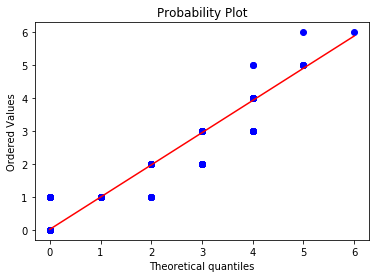

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 0.9460377097129822; expected: 1; difference: 0.05396229028701782
difference between std and mean :0.05127674341201782
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.00010927512047640175, pvalue=0.9918312665577753)


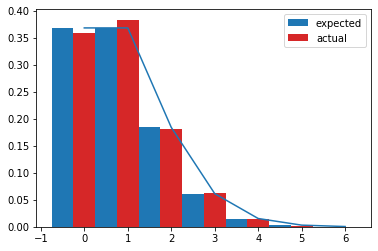

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.5, pvalue=0.47450184322152916)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


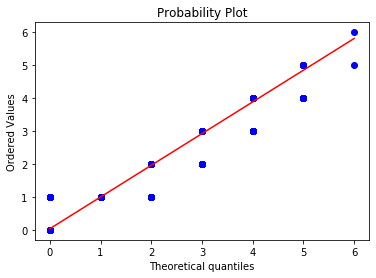

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 0.9877908229827881; expected: 1; difference: 0.012209177017211914
difference between std and mean :0.010744333267211914
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.5312006382472246e-07, pvalue=0.9995356303628636)


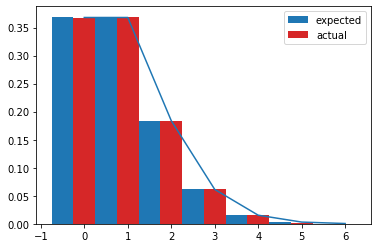

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.30126217618064843)
Levene: LeveneResult(statistic=0.01493736450818918, pvalue=0.9045950981425295)


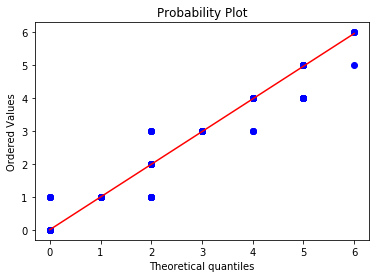

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 0.9771111868321896; expected: 1; difference: 0.02288881316781044
difference between std and mean :0.02209535613656044
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=5.851755066022897e-05, pvalue=0.9940222034839529)


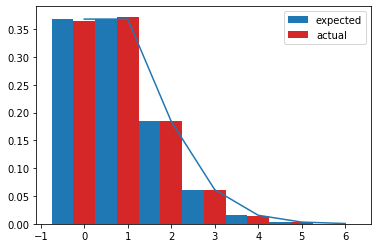

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.34272174133876104)
Levene: LeveneResult(statistic=0.01766750205882931, pvalue=0.8962927503357397)


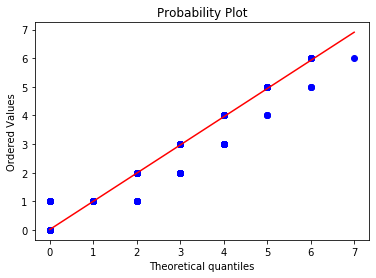

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 0.9954221807420254; expected: 1; difference: 0.004577819257974625
difference between std and mean :0.004150573164224625
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=1.0654789100971002e-06, pvalue=0.9991877613857885)


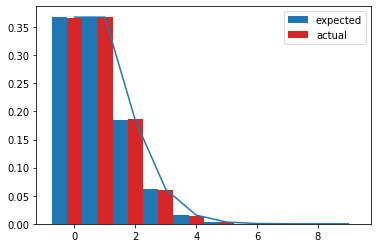

---- Sample data ----
MWU: MannwhitneyuResult(statistic=47.5, pvalue=0.43980218078345007)
Levene: LeveneResult(statistic=1.4716001756171405e-06, pvalue=0.9990454337220397)


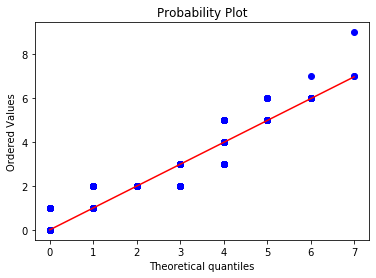

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 1.0062713099177927; expected: 1; difference: 0.006271309917792678
difference between std and mean :0.006500191753730178
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.4790455641133508)
Levene: LeveneResult(statistic=4.9260160424781634e-08, pvalue=0.9998260440594071)


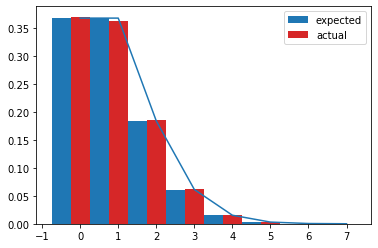

---- Sample data ----
MWU: MannwhitneyuResult(statistic=30.5, pvalue=0.45814889899892497)
Levene: LeveneResult(statistic=1.8506373133165708e-06, pvalue=0.9989337676100912)


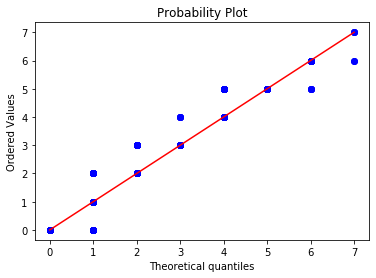

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 1.0018462985754013; expected: 1; difference: 0.0018462985754013062
difference between std and mean :0.001968368887901306
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.4790455641133508)
Levene: LeveneResult(statistic=1.6044579710201316e-06, pvalue=0.9990072145449502)


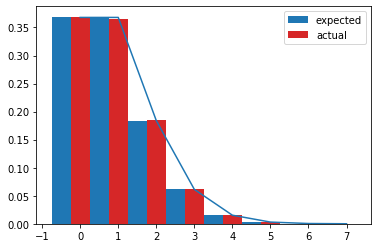

---- Sample data ----
MWU: MannwhitneyuResult(statistic=32.0, pvalue=0.3681384891705356)
Levene: LeveneResult(statistic=0.028105713390139148, pvalue=0.8690998870059614)


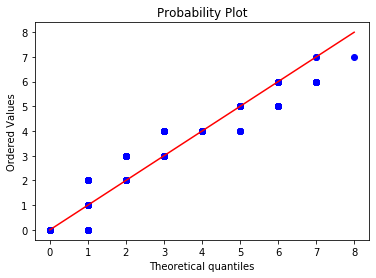

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 0.9992637592222309; expected: 1; difference: 0.000736240777769126
difference between std and mean :0.000671390924253501
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.9119206302020335e-09, pvalue=0.9999508692187141)


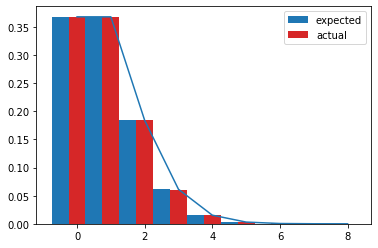

---- Sample data ----
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.3566515869392288)
Levene: LeveneResult(statistic=0.019117213269995912, pvalue=0.8916555524473524)


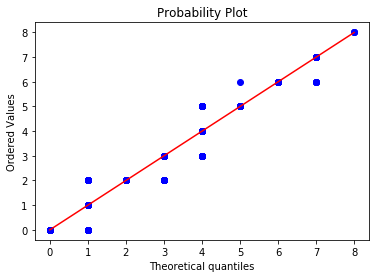

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 0.997058867229498; expected: 1; difference: 0.0029411327705020085
difference between std and mean :0.0029068004951113835
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=1.5172129686359332e-07, pvalue=0.9996934971272167)


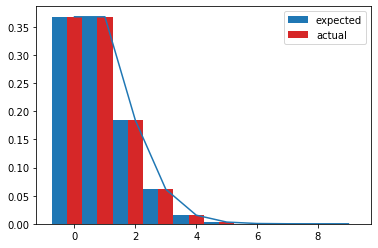

---- Sample data ----
MWU: MannwhitneyuResult(statistic=47.5, pvalue=0.4398921505284963)
Levene: LeveneResult(statistic=4.338596189924593e-07, pvalue=0.9994816944406926)


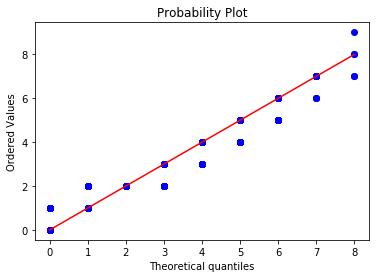

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 0.9971818920666919; expected: 1; difference: 0.002818107933308056
difference between std and mean :0.0027999881212963373
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=9.119855350198218e-08, pvalue=0.9997623678172864)


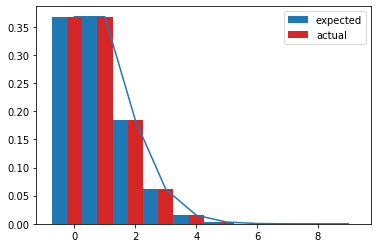

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.4849249884965778)
Levene: LeveneResult(statistic=1.2049915361712608e-07, pvalue=0.9997268487009645)


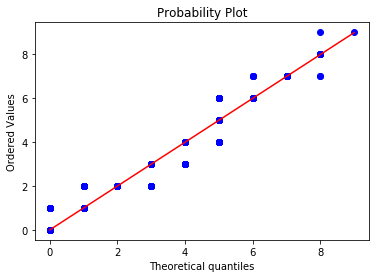

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 0.9982204436346365; expected: 1; difference: 0.0017795563653635327
difference between std and mean :0.0017700196221994702
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42502551244863873)
Levene: LeveneResult(statistic=9.212515056234535e-08, pvalue=0.9997611636713128)


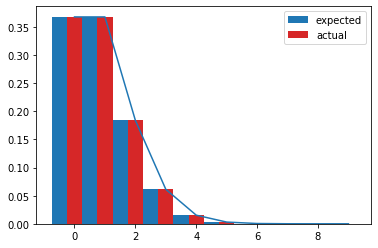

---- Sample data ----
MWU: MannwhitneyuResult(statistic=54.0, pvalue=0.4859565669766532)
Levene: LeveneResult(statistic=0.018913361281385564, pvalue=0.892062105545688)


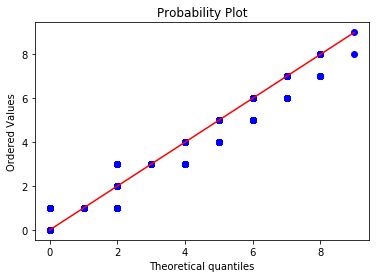

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 0.9986646175133842; expected: 1; difference: 0.0013353824866157993
difference between std and mean :0.0013303756964546665
MWU: MannwhitneyuResult(statistic=49.0, pvalue=0.4849193207024165)
Levene: LeveneResult(statistic=2.5511360518491895e-09, pvalue=0.9999602554090811)


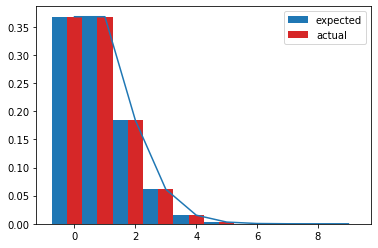

---- Sample data ----
MWU: MannwhitneyuResult(statistic=51.0, pvalue=0.4026620853091242)
Levene: LeveneResult(statistic=0.018809598559089626, pvalue=0.892356644703737)


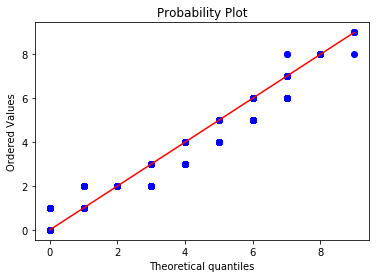

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 0.9992947578361395; expected: 1; difference: 0.0007052421638604756
difference between std and mean :0.0007026195594903584
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=3.797865953249695e-09, pvalue=0.9999514394771827)


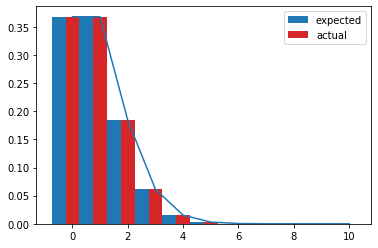

---- Sample data ----
MWU: MannwhitneyuResult(statistic=63.0, pvalue=0.4388283487879106)
Levene: LeveneResult(statistic=0.014765494171709309, pvalue=0.9044396866989178)


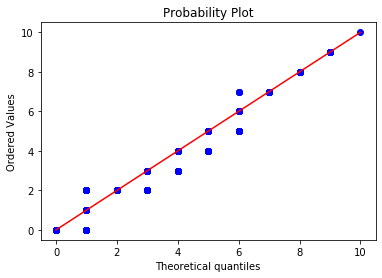

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 1.000257313249616; expected: 1; difference: 0.0002573132496159758
difference between std and mean :0.0002586841564458098
MWU: MannwhitneyuResult(statistic=59.0, pvalue=0.47381488164049806)
Levene: LeveneResult(statistic=3.3526759660069675e-13, pvalue=0.9999995452430156)


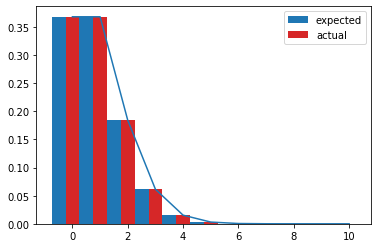

---- Sample data ----
MWU: MannwhitneyuResult(statistic=59.5, pvalue=0.48689297622562533)
Levene: LeveneResult(statistic=2.4641491461536676e-12, pvalue=0.9999987629272575)


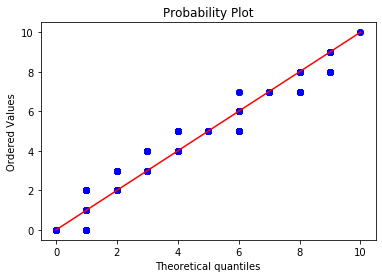

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 0.9998430609697946; expected: 1; difference: 0.00015693903020541633
difference between std and mean :0.00015622377446811164
MWU: MannwhitneyuResult(statistic=71.0, pvalue=0.48848262430702205)
Levene: LeveneResult(statistic=1.9139926732484021e-10, pvalue=0.9999890862047126)


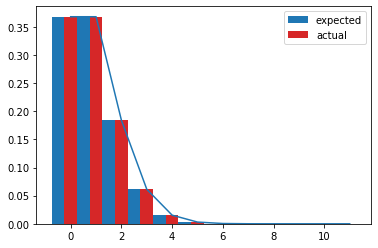

---- Sample data ----
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.48848512766098784)
Levene: LeveneResult(statistic=2.821271314976245e-11, pvalue=0.9999958098184583)


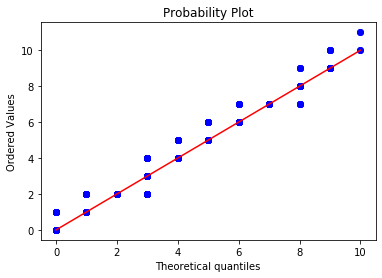

In [359]:
perform_test(seq='rule30',lamb=1)

### Rule 30 with lambda = 4 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 4.0812835693359375; expected: 4; difference: 0.0812835693359375
difference between std and mean :0.1086273193359375
MWU: MannwhitneyuResult(statistic=81.0, pvalue=0.4388343925435724)
Levene: LeveneResult(statistic=0.0019399121383166698, pvalue=0.9652333973329016)


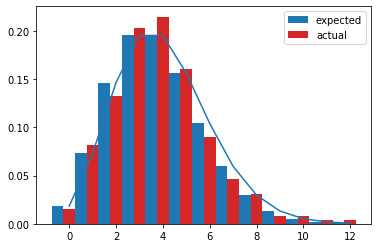

---- Sample data ----
MWU: MannwhitneyuResult(statistic=51.0, pvalue=0.04361122505059242)
Levene: LeveneResult(statistic=0.12981744421906705, pvalue=0.7217730013377158)


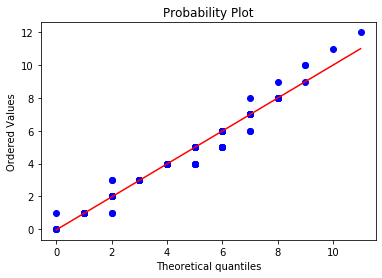

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 3.745849609375; expected: 4; difference: 0.254150390625
difference between std and mean :0.238525390625
MWU: MannwhitneyuResult(statistic=69.0, pvalue=0.4426045650376629)
Levene: LeveneResult(statistic=0.0010429250388190674, pvalue=0.9745285173404622)


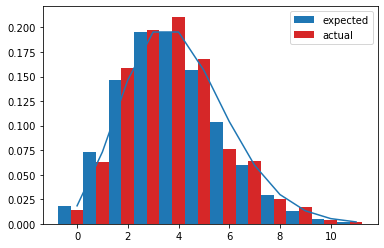

---- Sample data ----
MWU: MannwhitneyuResult(statistic=44.0, pvalue=0.05531570297130263)
Levene: LeveneResult(statistic=0.21825462289476447, pvalue=0.6449670424258414)


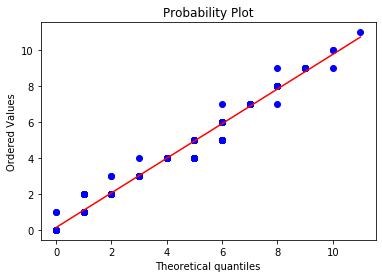

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 3.811446189880371; expected: 4; difference: 0.1885538101196289
difference between std and mean :0.1797647476196289
MWU: MannwhitneyuResult(statistic=60.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.0007191635559072293, pvalue=0.978871298039212)


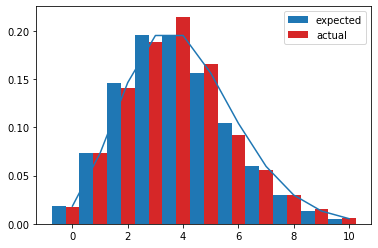

---- Sample data ----
MWU: MannwhitneyuResult(statistic=39.0, pvalue=0.08335160255127394)
Levene: LeveneResult(statistic=0.40179265907087464, pvalue=0.5333480759746675)


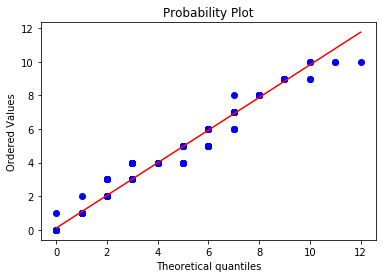

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 4.01755428314209; expected: 4; difference: 0.017554283142089844
difference between std and mean :0.022437095642089844
MWU: MannwhitneyuResult(statistic=95.0, pvalue=0.45426816835964046)
Levene: LeveneResult(statistic=0.0008623187714375638, pvalue=0.9767975263577363)


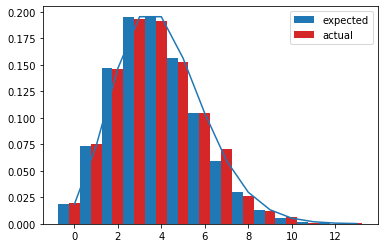

---- Sample data ----
MWU: MannwhitneyuResult(statistic=62.0, pvalue=0.05006286449125914)
Levene: LeveneResult(statistic=0.060748904588425405, pvalue=0.8072517438788804)


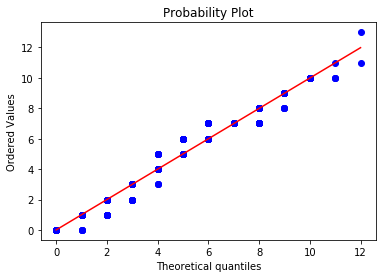

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 3.909416615962982; expected: 4; difference: 0.09058338403701782
difference between std and mean :0.08789783716201782
MWU: MannwhitneyuResult(statistic=84.0, pvalue=0.5)
Levene: LeveneResult(statistic=9.269467034839949e-06, pvalue=0.9975959463786612)


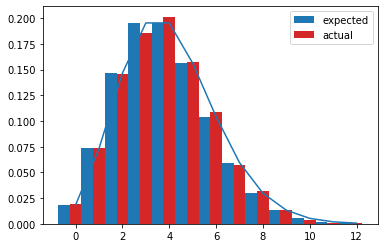

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.03970531299947112)
Levene: LeveneResult(statistic=0.13976992175535644, pvalue=0.7117923018312131)


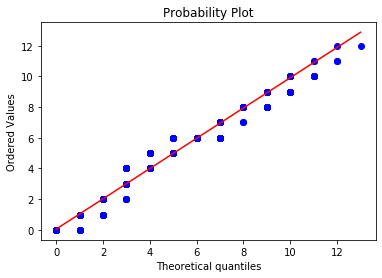

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 3.942380666732788; expected: 4; difference: 0.057619333267211914
difference between std and mean :0.056154489517211914
MWU: MannwhitneyuResult(statistic=185.0, pvalue=0.34729577804003875)
Levene: LeveneResult(statistic=9.894092191372185e-05, pvalue=0.9921156877301393)


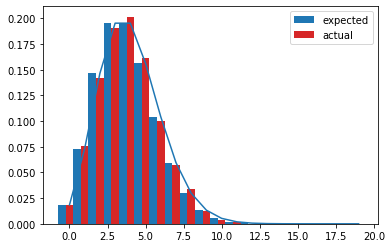

---- Sample data ----
MWU: MannwhitneyuResult(statistic=137.5, pvalue=0.04045681531641841)
Levene: LeveneResult(statistic=0.00042015298557438775, pvalue=0.9837536536922299)


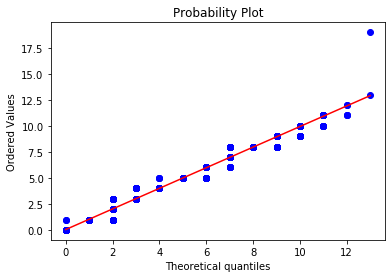

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 4.02496274933219; expected: 4; difference: 0.02496274933218956
difference between std and mean :0.02575620636343956
MWU: MannwhitneyuResult(statistic=110.0, pvalue=0.46693586932443376)
Levene: LeveneResult(statistic=5.295771392282578e-05, pvalue=0.9942452839461057)


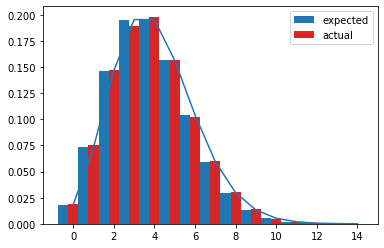

---- Sample data ----
MWU: MannwhitneyuResult(statistic=65.0, pvalue=0.024845647893835546)
Levene: LeveneResult(statistic=0.040879431913087926, pvalue=0.8412327137401532)


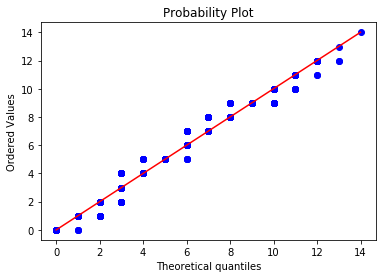

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 3.9902341924607754; expected: 4; difference: 0.009765807539224625
difference between std and mean :0.009338561445474625
MWU: MannwhitneyuResult(statistic=96.0, pvalue=0.4725222900881238)
Levene: LeveneResult(statistic=4.775948223552433e-05, pvalue=0.9945387583233309)


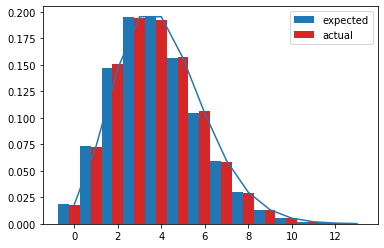

---- Sample data ----
MWU: MannwhitneyuResult(statistic=57.0, pvalue=0.030375271565295053)
Levene: LeveneResult(statistic=0.06551677044348414, pvalue=0.799994138321926)


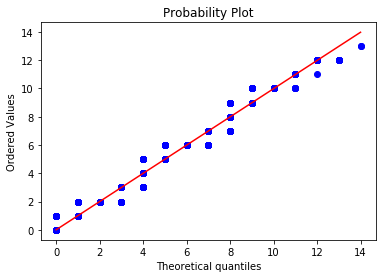

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 4.009292550152168; expected: 4; difference: 0.009292550152167678
difference between std and mean :0.009521431988105178
MWU: MannwhitneyuResult(statistic=112.0, pvalue=0.5)
Levene: LeveneResult(statistic=4.4398914993838564e-07, pvalue=0.9994730742760355)


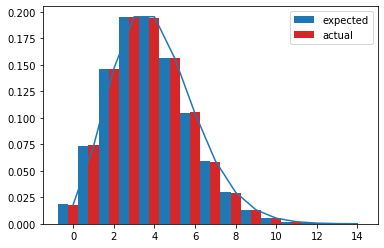

---- Sample data ----
MWU: MannwhitneyuResult(statistic=64.5, pvalue=0.02369376068042575)
Levene: LeveneResult(statistic=0.038898203350769926, pvalue=0.8450751969438017)


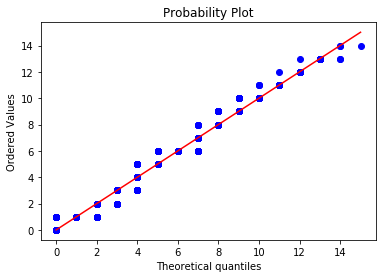

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 3.9839629977941513; expected: 4; difference: 0.016037002205848694
difference between std and mean :0.015914931893348694
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.7321058849957463e-06, pvalue=0.9986914321478646)


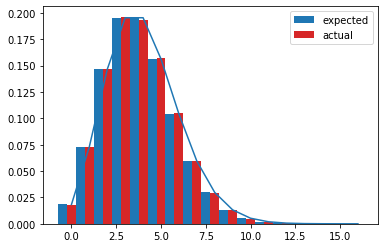

---- Sample data ----
MWU: MannwhitneyuResult(statistic=81.5, pvalue=0.015123638654162714)
Levene: LeveneResult(statistic=0.011067703659150096, pvalue=0.9168712938958181)


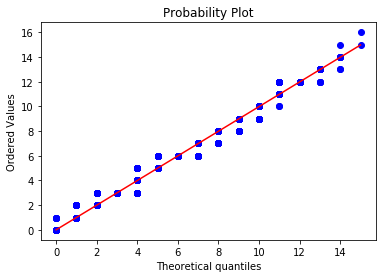

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 3.983211513128481; expected: 4; difference: 0.016788486871519126
difference between std and mean :0.0167236370180035
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.06790862883045e-06, pvalue=0.9988615519803791)


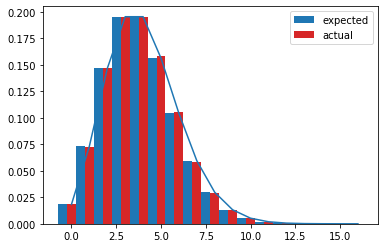

---- Sample data ----
MWU: MannwhitneyuResult(statistic=83.0, pvalue=0.017229069469353236)
Levene: LeveneResult(statistic=0.011475998559390714, pvalue=0.9153577735010205)


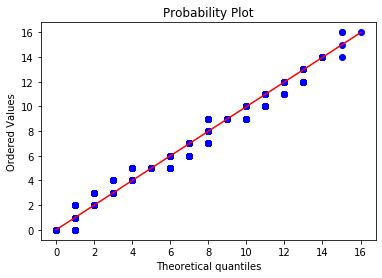

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 3.986362456096686; expected: 4; difference: 0.013637543903314064
difference between std and mean :0.01360321162792344
MWU: MannwhitneyuResult(statistic=144.0, pvalue=0.5)
Levene: LeveneResult(statistic=4.572874921008759e-06, pvalue=0.9983070582810695)


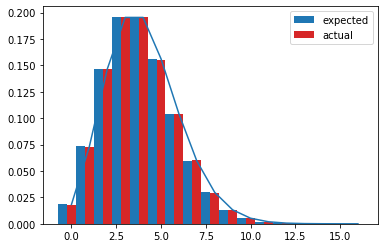

---- Sample data ----
MWU: MannwhitneyuResult(statistic=82.5, pvalue=0.01668671287519965)
Levene: LeveneResult(statistic=0.011000584622199772, pvalue=0.9171227858547042)


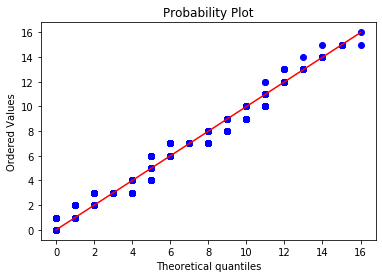

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 3.993395805030559; expected: 4; difference: 0.006604194969440869
difference between std and mean :0.00658607515742915
MWU: MannwhitneyuResult(statistic=141.0, pvalue=0.4588471639749423)
Levene: LeveneResult(statistic=5.310516745564465e-07, pvalue=0.9994230794083784)


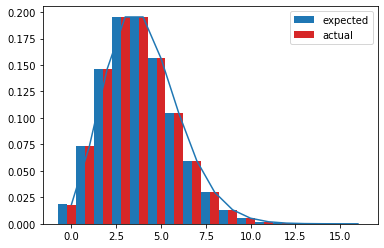

---- Sample data ----
MWU: MannwhitneyuResult(statistic=82.0, pvalue=0.01580388521715741)
Levene: LeveneResult(statistic=0.01119340618012905, pvalue=0.9164023585712804)


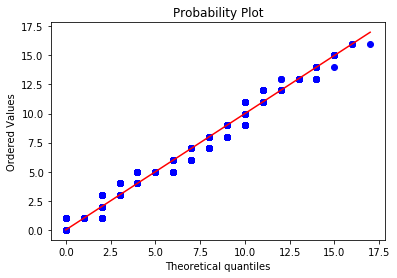

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 3.993089675812371; expected: 4; difference: 0.006910324187629158
difference between std and mean :0.006900787444465095
MWU: MannwhitneyuResult(statistic=180.0, pvalue=0.5)
Levene: LeveneResult(statistic=2.335445992992895e-07, pvalue=0.9996170788010148)


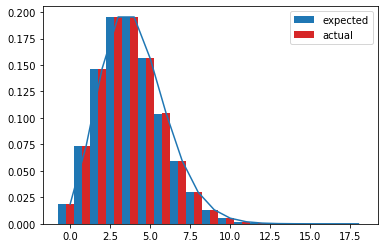

---- Sample data ----
MWU: MannwhitneyuResult(statistic=101.0, pvalue=0.010111276988944767)
Levene: LeveneResult(statistic=0.0024901172092874012, pvalue=0.9604770641000676)


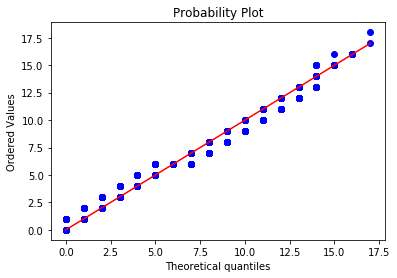

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 3.998709917043414; expected: 4; difference: 0.0012900829565860583
difference between std and mean :0.0012850761664249255
MWU: MannwhitneyuResult(statistic=162.0, pvalue=0.4936888695222025)
Levene: LeveneResult(statistic=1.9589354111633584e-08, pvalue=0.9998891445146243)


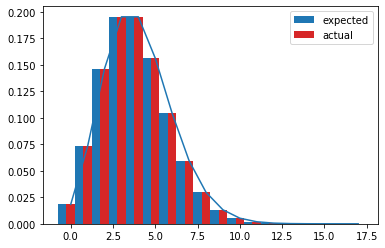

---- Sample data ----
MWU: MannwhitneyuResult(statistic=91.5, pvalue=0.012976438363224466)
Levene: LeveneResult(statistic=0.0054030034896098665, pvalue=0.9418349123051503)


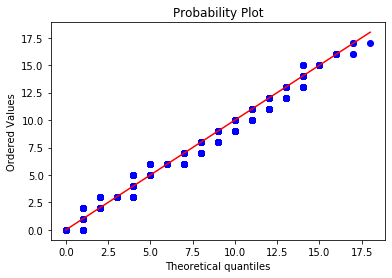

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 3.9978449344566234; expected: 4; difference: 0.002155065543376633
difference between std and mean :0.002152442939006516
MWU: MannwhitneyuResult(statistic=180.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.3157984770414013e-11, pvalue=0.999997125840975)


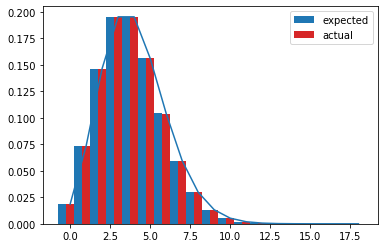

---- Sample data ----
MWU: MannwhitneyuResult(statistic=102.5, pvalue=0.011507401360997255)
Levene: LeveneResult(statistic=0.0025246042136124257, pvalue=0.9602045527573481)


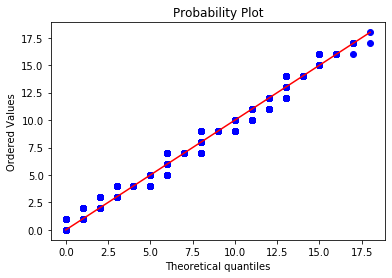

In [360]:
perform_test(seq='rule30',lamb=4)

### Rule 30 with lambda = 32 from N=2ˆ10 up to 2ˆ26

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 21.609375; expected: 32; difference: 10.390625
difference between std and mean :10.265625
MWU: MannwhitneyuResult(statistic=553.0, pvalue=0.0005533038940756862)
Levene: LeveneResult(statistic=0.08578826211489415, pvalue=0.7703237146545907)


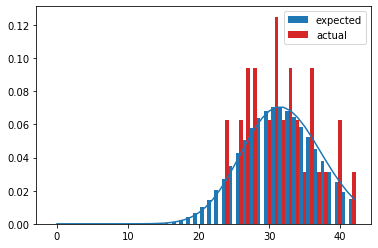

---- Sample data ----
MWU: MannwhitneyuResult(statistic=730.5, pvalue=0.011922955214343455)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


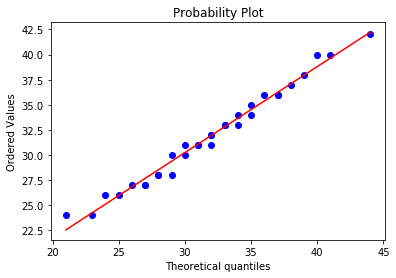

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 28.634521484375; expected: 32; difference: 3.365478515625
difference between std and mean :3.287353515625
MWU: MannwhitneyuResult(statistic=693.0, pvalue=0.022053222803427187)
Levene: LeveneResult(statistic=0.12148026513650989, pvalue=0.7283065927739139)


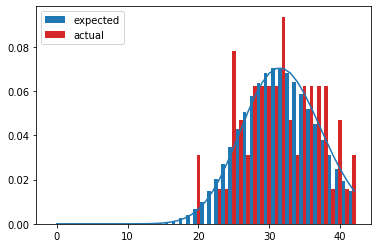

---- Sample data ----
MWU: MannwhitneyuResult(statistic=612.5, pvalue=0.0004609166920790726)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


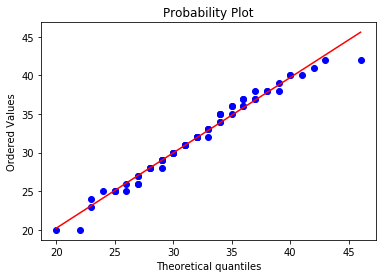

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 35.154052734375; expected: 32; difference: 3.154052734375
difference between std and mean :3.200927734375
MWU: MannwhitneyuResult(statistic=963.0, pvalue=0.045140087544489525)
Levene: LeveneResult(statistic=0.007409743558570606, pvalue=0.9315822076408832)


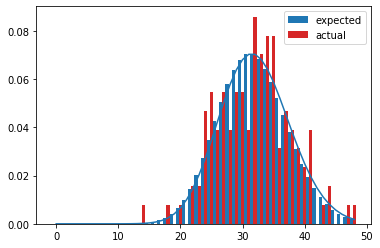

---- Sample data ----
MWU: MannwhitneyuResult(statistic=714.5, pvalue=2.0584188424427145e-05)
Levene: LeveneResult(statistic=0.004903964037597048, pvalue=0.9443167967406659)


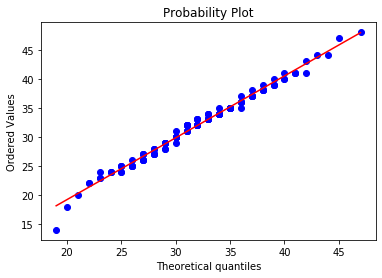

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 34.83128356933594; expected: 32; difference: 2.8312835693359375
difference between std and mean :2.8586273193359375
MWU: MannwhitneyuResult(statistic=1101.0, pvalue=0.05087465482129451)
Levene: LeveneResult(statistic=0.001931950284863303, pvalue=0.9650270382033688)


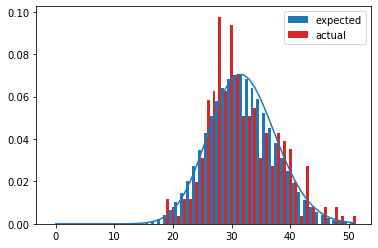

---- Sample data ----
MWU: MannwhitneyuResult(statistic=766.5, pvalue=3.7101120070079023e-06)
Levene: LeveneResult(statistic=0.0029184236220641535, pvalue=0.9570229573466993)


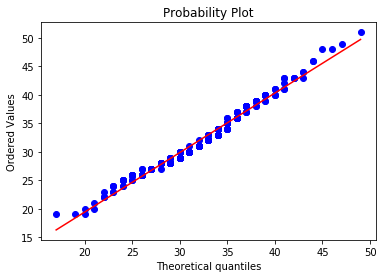

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 31.761474609375; expected: 32; difference: 0.238525390625
difference between std and mean :0.222900390625
MWU: MannwhitneyuResult(statistic=1024.0, pvalue=0.17450089054115442)
Levene: LeveneResult(statistic=0.00020573598880034853, pvalue=0.9885863348036444)


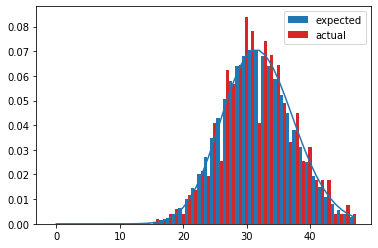

---- Sample data ----
MWU: MannwhitneyuResult(statistic=563.0, pvalue=5.172374448960698e-07)
Levene: LeveneResult(statistic=0.010430403318791586, pvalue=0.9188715557938564)


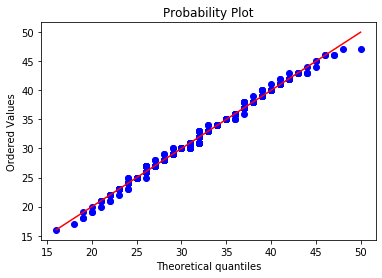

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 29.80363368988037; expected: 32; difference: 2.196366310119629
difference between std and mean :2.187577247619629
MWU: MannwhitneyuResult(statistic=1566.0, pvalue=0.06535350404816631)
Levene: LeveneResult(statistic=1.0914024346858238e-05, pvalue=0.9973695687565693)


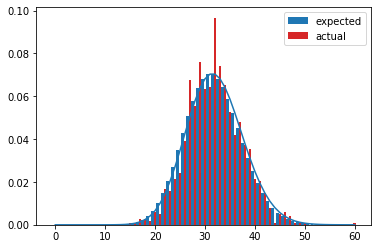

---- Sample data ----
MWU: MannwhitneyuResult(statistic=987.5, pvalue=1.0009036326052543e-07)
Levene: LeveneResult(statistic=0.00047847513090116584, pvalue=0.9825847362503926)


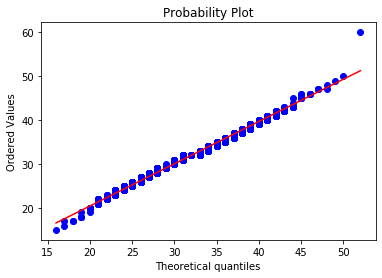

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 32.19626522064209; expected: 32; difference: 0.19626522064208984
difference between std and mean :0.20114803314208984
MWU: MannwhitneyuResult(statistic=1430.0, pvalue=0.21139169999614366)
Levene: LeveneResult(statistic=0.00017481673807293442, pvalue=0.9894747655188023)


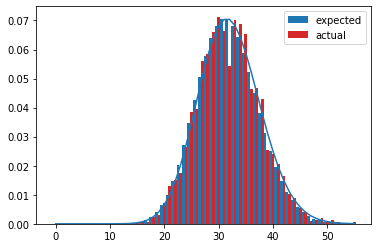

---- Sample data ----
MWU: MannwhitneyuResult(statistic=721.0, pvalue=1.655347922111854e-08)
Levene: LeveneResult(statistic=0.0015494235766191876, pvalue=0.9686725558862761)


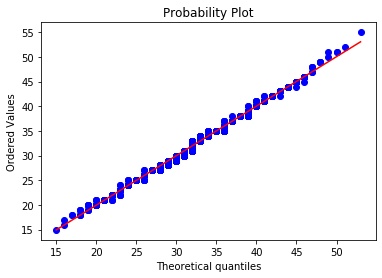

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 30.987053334712982; expected: 32; difference: 1.0129466652870178
difference between std and mean :1.0102611184120178
MWU: MannwhitneyuResult(statistic=1367.0, pvalue=0.19264025832121245)
Levene: LeveneResult(statistic=0.0017781939998697698, pvalue=0.9664421252141534)


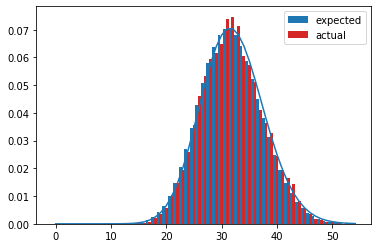

---- Sample data ----
MWU: MannwhitneyuResult(statistic=692.0, pvalue=2.6587072096783707e-08)
Levene: LeveneResult(statistic=0.0012236104493805618, pvalue=0.9721601447541299)


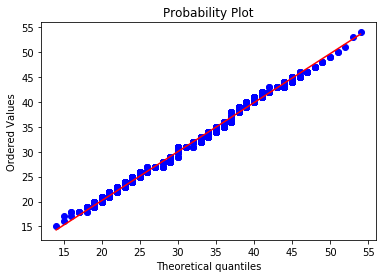

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 31.907468557357788; expected: 32; difference: 0.09253144264221191
difference between std and mean :0.09106659889221191
MWU: MannwhitneyuResult(statistic=1426.0, pvalue=0.3034305786198833)
Levene: LeveneResult(statistic=9.779303760746389e-05, pvalue=0.9921280633815416)


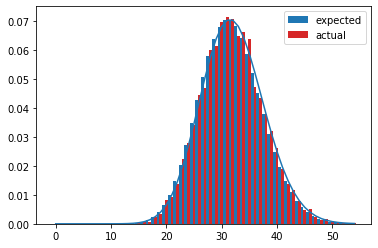

---- Sample data ----
MWU: MannwhitneyuResult(statistic=616.0, pvalue=2.4203154265569214e-09)
Levene: LeveneResult(statistic=0.002309213005445217, pvalue=0.9617617423496214)


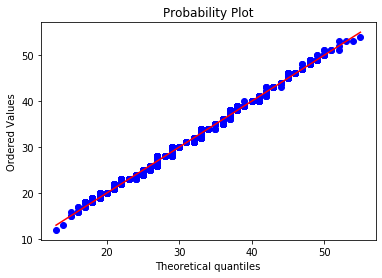

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 31.85272153839469; expected: 32; difference: 0.14727846160531044
difference between std and mean :0.14648500457406044
MWU: MannwhitneyuResult(statistic=1512.0, pvalue=0.2625678666326824)
Levene: LeveneResult(statistic=3.559408472515538e-05, pvalue=0.9952504005838402)


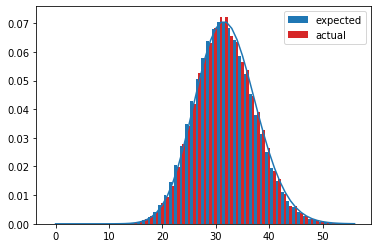

---- Sample data ----
MWU: MannwhitneyuResult(statistic=692.5, pvalue=2.9640563574044505e-09)
Levene: LeveneResult(statistic=0.0018258676854814374, pvalue=0.9659927123744088)


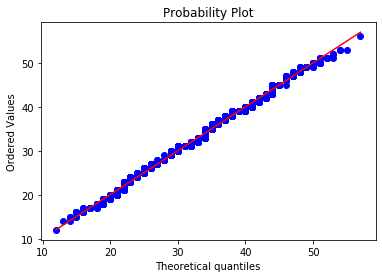

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 31.315002258867025; expected: 32; difference: 0.6849977411329746
difference between std and mean :0.6845704950392246
MWU: MannwhitneyuResult(statistic=1640.0, pvalue=0.29505410314866065)
Levene: LeveneResult(statistic=9.289764978166695e-05, pvalue=0.992326390849747)


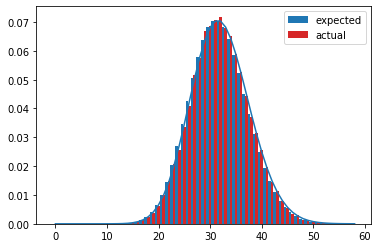

---- Sample data ----
MWU: MannwhitneyuResult(statistic=697.5, pvalue=3.9145455438256634e-10)
Levene: LeveneResult(statistic=0.0007290012030082236, pvalue=0.9785061112321963)


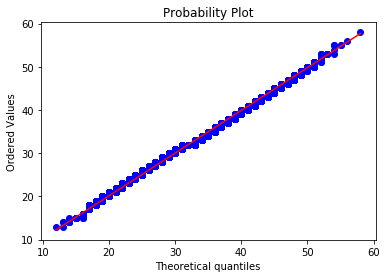

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 31.793533272808418; expected: 32; difference: 0.20646672719158232
difference between std and mean :0.20623784535564482
MWU: MannwhitneyuResult(statistic=1690.0, pvalue=0.2825825808813537)
Levene: LeveneResult(statistic=1.3985175383930265e-05, pvalue=0.9970224922897492)


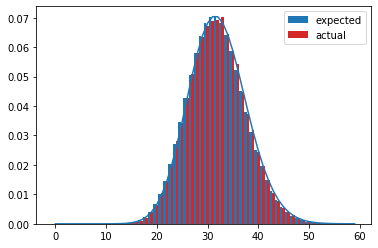

---- Sample data ----
MWU: MannwhitneyuResult(statistic=713.5, pvalue=2.147014794168859e-10)
Levene: LeveneResult(statistic=0.0006357617269238529, pvalue=0.9799266091420507)


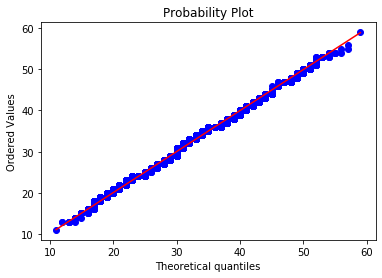

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 31.850326523184776; expected: 32; difference: 0.1496734768152237
difference between std and mean :0.1495514065027237
MWU: MannwhitneyuResult(statistic=1809.0, pvalue=0.39696132030239184)
Levene: LeveneResult(statistic=1.01280008205296e-05, pvalue=0.9974660594781415)


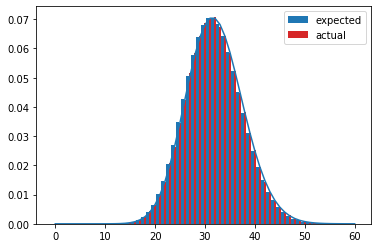

---- Sample data ----
MWU: MannwhitneyuResult(statistic=623.0, pvalue=4.51636996214342e-12)
Levene: LeveneResult(statistic=0.0004969336534231829, pvalue=0.9822520486900048)


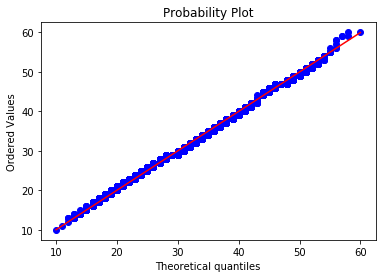

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 32.00738143500348; expected: 32; difference: 0.007381435003480874
difference between std and mean :0.007446284856996499
MWU: MannwhitneyuResult(statistic=1789.0, pvalue=0.3580316293164489)
Levene: LeveneResult(statistic=3.344808974090373e-06, pvalue=0.9985438010696989)


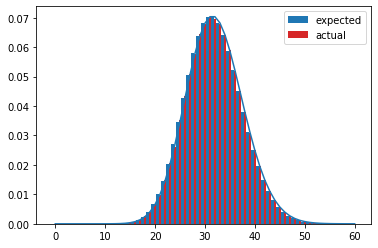

---- Sample data ----
MWU: MannwhitneyuResult(statistic=687.5, pvalue=5.0540965482061844e-11)
Levene: LeveneResult(statistic=0.0005240733365238766, pvalue=0.9817739282495166)


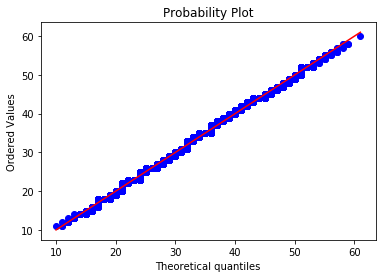

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 31.948577879680663; expected: 32; difference: 0.05142212031933724
difference between std and mean :0.051387788043946614
MWU: MannwhitneyuResult(statistic=2016.0, pvalue=0.440325449602017)
Levene: LeveneResult(statistic=1.2089102235994794e-06, pvalue=0.9991244613701284)


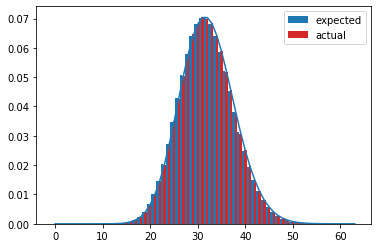

---- Sample data ----
MWU: MannwhitneyuResult(statistic=652.0, pvalue=6.887064182406179e-13)
Levene: LeveneResult(statistic=0.00023061200740108291, pvalue=0.9879078783190122)


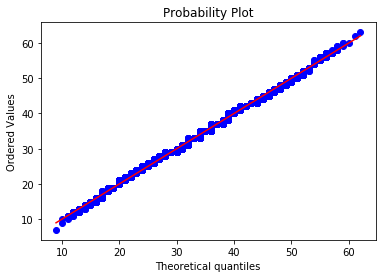

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 31.93394184079716; expected: 32; difference: 0.0660581592028393
difference between std and mean :0.06604003939082759
MWU: MannwhitneyuResult(statistic=1950.0, pvalue=0.43411200294930163)
Levene: LeveneResult(statistic=3.2848225574355587e-07, pvalue=0.9995436265100804)


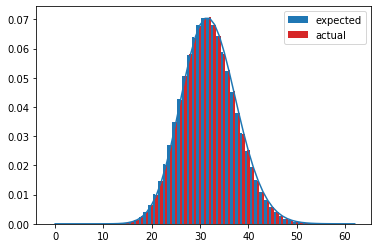

---- Sample data ----
MWU: MannwhitneyuResult(statistic=613.0, pvalue=6.034620681612968e-13)
Levene: LeveneResult(statistic=0.0003180379303222143, pvalue=0.9858002489284723)


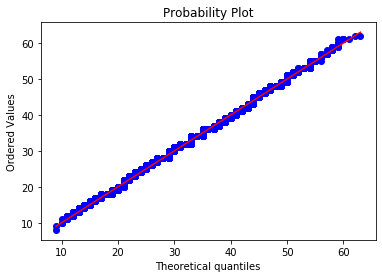

In [361]:
perform_test(seq='rule30',lamb=32)